# ufunc_call_f4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

M, N = 100, 100

x1 = allocate(shape=(M, N), dtype="f4")
x2 = allocate(shape=(M, N), dtype="f4")
out = allocate(shape=(M, N), dtype="f4")

x1[:] = np.random.rand(*x1.shape) + 1
x2[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def add_call_f4_numpy(x1, x2, out):
    out[:] = x1 + x2

def subtract_call_f4_numpy(x1, x2, out):
    out[:] = x1 - x2

def multiply_call_f4_numpy(x1, x2, out):
    out[:] = x1 * x2

def true_divide_call_f4_numpy(x1, x2, out):
    out[:] = x1 / x2

def sin_call_f4_numpy(x1, out):
    out[:] = np.sin(x1)

def sqrt_call_f4_numpy(x1, out):
    out[:] = np.sqrt(x1)

def arctan_call_f4_numpy(x1, out):
    out[:] = np.arctan(x1)

def sinh_call_f4_numpy(x1, out):
    out[:] = np.sinh(x1)

def exp_call_f4_numpy(x1, out):
    out[:] = np.exp(x1)

def log_call_f4_numpy(x1, out):
    out[:] = np.log(x1)

out[:] = 0
add_call_f4_numpy(x1, x2, out)
print(f"add_call_f4_numpy = {out}")

out[:] = 0
subtract_call_f4_numpy(x1, x2, out)
print(f"subtract_call_f4_numpy = {out}")

out[:] = 0
multiply_call_f4_numpy(x1, x2, out)
print(f"multiply_call_f4_numpy = {out}")

out[:] = 0
true_divide_call_f4_numpy(x1, x2, out)
print(f"true_divide_call_f4_numpy = {out}")

out[:] = 0
sin_call_f4_numpy(x1, out)
print(f"sin_call_f4_numpy = {out}")

out[:] = 0
sqrt_call_f4_numpy(x1, out)
print(f"sqrt_call_f4_numpy = {out}")

out[:] = 0
arctan_call_f4_numpy(x1, out)
print(f"arctan_call_f4_numpy = {out}")

out[:] = 0
sinh_call_f4_numpy(x1, out)
print(f"sinh_call_f4_numpy = {out}")

out[:] = 0
exp_call_f4_numpy(x1, out)
print(f"exp_call_f4_numpy = {out}")

out[:] = 0
log_call_f4_numpy(x1, out)
print(f"log_call_f4_numpy = {out}")

add_call_f4_numpy = [[2.9947243 2.6178765 2.885109  ... 2.7037554 2.803265  2.8674102]
 [2.4927971 2.904996  2.9513025 ... 2.2379909 2.3088262 2.712206 ]
 [2.9244823 3.5847535 2.5963013 ... 3.4739454 2.883689  3.1127472]
 ...
 [2.725282  3.4004478 2.6720319 ... 3.2267776 2.6608639 2.5390358]
 [3.3560884 3.4454062 3.0173295 ... 3.6300163 2.4698176 3.144953 ]
 [3.4810982 3.4017873 3.3165097 ... 2.4389691 3.2233293 2.8818994]]
subtract_call_f4_numpy = [[ 0.84880495 -0.5045084   0.608564   ... -0.5437703  -0.5007304
   0.8541409 ]
 [ 0.09302211  0.450778    0.26971745 ... -0.07501733  0.30019403
  -0.27015495]
 [-0.8305583  -0.36829603  0.3949933  ... -0.28923368  0.8794625
  -0.48944485]
 ...
 [ 0.35406637  0.05204463 -0.4869026  ... -0.25365984  0.42747092
  -0.18369853]
 [-0.4137268   0.3733518   0.8002565  ... -0.18798661  0.3963158
   0.289546  ]
 [-0.30060947 -0.02469051  0.2238338  ... -0.38548434 -0.18002367
   0.04524589]]
multiply_call_f4_numpy = [[2.061976  1.6496874 1.988376  .

# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
NONE = 0
ADD = 1
MULTIPLY = 2
SQUARE = 3
EXP = 4
LOG = 5
ABSDIFF = 6
SUBTRACT = 7
TRUE_DIVIDE = 8
SIN = 9
SQRT = 10
ARCTAN = 11
SINH = 12

def add_call_f4_pynq(x1, x2, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, ADD)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def subtract_call_f4_pynq(x1, x2, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, SUBTRACT)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def multiply_call_f4_pynq(x1, x2, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, MULTIPLY)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def true_divide_call_f4_pynq(x1, x2, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, TRUE_DIVIDE)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def sin_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, SIN)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def sqrt_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, SQRT)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def arctan_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, ARCTAN)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def sinh_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, SINH)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def exp_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, EXP)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

def log_call_f4_pynq(x1, out):
    overlay.ufunc_call_f4_0.mmio.write(0x10, LOG)  # Set the args
    overlay.ufunc_call_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

out[:] = 0
add_call_f4_pynq(x1, x2, out)
print(f"add_call_f4_pynq = {out}")

out[:] = 0
subtract_call_f4_pynq(x1, x2, out)
print(f"subtract_call_f4_pynq = {out}")

out[:] = 0
multiply_call_f4_pynq(x1, x2, out)
print(f"multiply_call_f4_pynq = {out}")

out[:] = 0
true_divide_call_f4_pynq(x1, x2, out)
print(f"true_divide_call_f4_pynq = {out}")

out[:] = 0
sin_call_f4_pynq(x1, out)
print(f"sin_call_f4_pynq = {out}")

out[:] = 0
sqrt_call_f4_pynq(x1, out)
print(f"sqrt_call_f4_pynq = {out}")

out[:] = 0
arctan_call_f4_pynq(x1, out)
print(f"arctan_call_f4_pynq = {out}")

out[:] = 0
sinh_call_f4_pynq(x1, out)
print(f"sinh_call_f4_pynq = {out}")

out[:] = 0
exp_call_f4_pynq(x1, out)
print(f"exp_call_f4_pynq = {out}")

out[:] = 0
log_call_f4_pynq(x1, out)
print(f"log_call_f4_pynq = {out}")

add_call_f4_pynq = [[2.9947243 2.6178765 2.885109  ... 2.7037554 2.803265  2.8674102]
 [2.4927971 2.904996  2.9513025 ... 2.2379909 2.3088262 2.712206 ]
 [2.9244823 3.5847535 2.5963013 ... 3.4739454 2.883689  3.1127472]
 ...
 [2.725282  3.4004478 2.6720319 ... 3.2267776 2.6608639 2.5390358]
 [3.3560884 3.4454062 3.0173295 ... 3.6300163 2.4698176 3.144953 ]
 [3.4810982 3.4017873 3.3165097 ... 2.4389691 3.2233293 2.8818994]]
subtract_call_f4_pynq = [[ 0.84880495 -0.5045084   0.608564   ... -0.5437703  -0.5007304
   0.8541409 ]
 [ 0.09302211  0.450778    0.26971745 ... -0.07501733  0.30019403
  -0.27015495]
 [-0.8305583  -0.36829603  0.3949933  ... -0.28923368  0.8794625
  -0.48944485]
 ...
 [ 0.35406637  0.05204463 -0.4869026  ... -0.25365984  0.42747092
  -0.18369853]
 [-0.4137268   0.3733518   0.8002565  ... -0.18798661  0.3963158
   0.289546  ]
 [-0.30060947 -0.02469051  0.2238338  ... -0.38548434 -0.18002367
   0.04524589]]
multiply_call_f4_pynq = [[2.061976  1.6496874 1.988376  ... 

# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 ufunc_call_f4_pybind11

#include "defines.h"

#define NONE 0
#define ADD 1
#define MULTIPLY 2
#define SQUARE 3
#define EXP 4
#define LOG 5
#define ABSDIFF 6
#define SUBTRACT 7
#define TRUE_DIVIDE 8
#define SIN 9
#define SQRT 10
#define ARCTAN 11
#define SINH 12

void add_call_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(ADD);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void subtract_call_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(SUBTRACT);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void multiply_call_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(MULTIPLY);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void true_divide_call_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(TRUE_DIVIDE);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    axi_dma_1_mm2s_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_1_mm2s_dmacr_rs_rw(0x1);
    axi_dma_1_mm2s_sa_source_address_rw(x2_addr);
    axi_dma_1_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void sin_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(SIN);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void sqrt_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(SQRT);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void arctan_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(ARCTAN);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void sinh_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(SINH);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void exp_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(EXP);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

void log_call_f4(unsigned int x1_addr, int out_addr, unsigned int nbytes)
{
    init();
    
    ufunc_call_f4_0_args_args_w(LOG);
    ufunc_call_f4_0_ctrl_ap_start_rw(0x1);

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);

    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(nbytes);

    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(nbytes);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"ufunc_call_f4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import ufunc_call_f4_pybind11 as calc

def add_call_f4_pybind11(x1, x2, out):
    calc.add_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def subtract_call_f4_pybind11(x1, x2, out):
    calc.subtract_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def multiply_call_f4_pybind11(x1, x2, out):
    calc.multiply_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def true_divide_call_f4_pybind11(x1, x2, out):
    calc.true_divide_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def sin_call_f4_pybind11(x1, out):
    calc.sin_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def sqrt_call_f4_pybind11(x1, out):
    calc.sqrt_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def arctan_call_f4_pybind11(x1, out):
    calc.arctan_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def sinh_call_f4_pybind11(x1, out):
    calc.sinh_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def exp_call_f4_pybind11(x1, out):
    calc.exp_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def log_call_f4_pybind11(x1, out):
    calc.log_call_f4(x1.physical_address, out.physical_address, x1.nbytes)


out[:] = 0
add_call_f4_pybind11(x1, x2, out)
print(f"add_call_f4_pybind11 = {out}")

out[:] = 0
subtract_call_f4_pybind11(x1, x2, out)
print(f"subtract_call_f4_pybind11 = {out}")

out[:] = 0
multiply_call_f4_pybind11(x1, x2, out)
print(f"multiply_call_f4_pybind11 = {out}")

out[:] = 0
true_divide_call_f4_pybind11(x1, x2, out)
print(f"true_divide_call_f4_pybind11 = {out}")

out[:] = 0
sin_call_f4_pybind11(x1, out)
print(f"sin_call_f4_pybind11 = {out}")

out[:] = 0
sqrt_call_f4_pybind11(x1, out)
print(f"sqrt_call_f4_pybind11 = {out}")

out[:] = 0
arctan_call_f4_pybind11(x1, out)
print(f"arctan_call_f4_pybind11 = {out}")

out[:] = 0
sinh_call_f4_pybind11(x1, out)
print(f"sinh_call_f4_pybind11 = {out}")

out[:] = 0
exp_call_f4_pybind11(x1, out)
print(f"exp_call_f4_pybind11 = {out}")

out[:] = 0
log_call_f4_pybind11(x1, out)
print(f"log_call_f4_pybind11 = {out}")

add_call_f4_pybind11 = [[2.9947243 2.6178765 2.885109  ... 2.7037554 2.803265  2.8674102]
 [2.4927971 2.904996  2.9513025 ... 2.2379909 2.3088262 2.712206 ]
 [2.9244823 3.5847535 2.5963013 ... 3.4739454 2.883689  3.1127472]
 ...
 [2.725282  3.4004478 2.6720319 ... 3.2267776 2.6608639 2.5390358]
 [3.3560884 3.4454062 3.0173295 ... 3.6300163 2.4698176 3.144953 ]
 [3.4810982 3.4017873 3.3165097 ... 2.4389691 3.2233293 2.8818994]]
subtract_call_f4_pybind11 = [[ 0.84880495 -0.5045084   0.608564   ... -0.5437703  -0.5007304
   0.8541409 ]
 [ 0.09302211  0.450778    0.26971745 ... -0.07501733  0.30019403
  -0.27015495]
 [-0.8305583  -0.36829603  0.3949933  ... -0.28923368  0.8794625
  -0.48944485]
 ...
 [ 0.35406637  0.05204463 -0.4869026  ... -0.25365984  0.42747092
  -0.18369853]
 [-0.4137268   0.3733518   0.8002565  ... -0.18798661  0.3963158
   0.289546  ]
 [-0.30060947 -0.02469051  0.2238338  ... -0.38548434 -0.18002367
   0.04524589]]
multiply_call_f4_pybind11 = [[2.061976  1.6496874 1.

# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_ufunc_call_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

# Add all C definitions below...

ffibuilder.cdef(
    r"""
void add_call_f4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void subtract_call_f4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void multiply_call_f4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void true_divide_call_f4(unsigned int x1_addr, unsigned int x2_addr, int out_addr, unsigned int nbytes);
void sin_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void sqrt_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void arctan_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void sinh_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void exp_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
void log_call_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int nbytes);
    """
)

with open("ufunc_call_f4.c") as f:
    ffibuilder.set_source("ufunc_call_f4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_ufunc_call_f4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_ufunc_call_f4_cffi.py
cp ufunc_call_f4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp ufunc_call_f4_pybind11.so ../

generating ./ufunc_call_f4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/ufunc_call_f4'
running build_ext
building 'ufunc_call_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c ufunc_call_f4_cffi.c -o ./ufunc_call_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./ufunc_call_f4_cffi.o -o ./ufunc_call_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from ufunc_call_f4_cffi.c:569:0:
defines.h:171:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from ufunc_call_f4_cffi import lib as calc

def add_call_f4_cffi(x1, x2, out):
    calc.add_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def subtract_call_f4_cffi(x1, x2, out):
    calc.subtract_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def multiply_call_f4_cffi(x1, x2, out):
    calc.multiply_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def true_divide_call_f4_cffi(x1, x2, out):
    calc.true_divide_call_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.nbytes)

def sin_call_f4_cffi(x1, out):
    calc.sin_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def sqrt_call_f4_cffi(x1, out):
    calc.sqrt_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def arctan_call_f4_cffi(x1, out):
    calc.arctan_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def sinh_call_f4_cffi(x1, out):
    calc.sinh_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def exp_call_f4_cffi(x1, out):
    calc.exp_call_f4(x1.physical_address, out.physical_address, x1.nbytes)

def log_call_f4_cffi(x1, out):
    calc.log_call_f4(x1.physical_address, out.physical_address, x1.nbytes)


out[:] = 0
add_call_f4_cffi(x1, x2, out)
print(f"add_call_f4_cffi = {out}")

out[:] = 0
subtract_call_f4_cffi(x1, x2, out)
print(f"subtract_call_f4_cffi = {out}")

out[:] = 0
multiply_call_f4_cffi(x1, x2, out)
print(f"multiply_call_f4_cffi = {out}")

out[:] = 0
true_divide_call_f4_cffi(x1, x2, out)
print(f"true_divide_call_f4_cffi = {out}")

out[:] = 0
sin_call_f4_cffi(x1, out)
print(f"sin_call_f4_cffi = {out}")

out[:] = 0
sqrt_call_f4_cffi(x1, out)
print(f"sqrt_call_f4_cffi = {out}")

out[:] = 0
arctan_call_f4_cffi(x1, out)
print(f"arctan_call_f4_cffi = {out}")

out[:] = 0
sinh_call_f4_cffi(x1, out)
print(f"sinh_call_f4_cffi = {out}")

out[:] = 0
exp_call_f4_cffi(x1, out)
print(f"exp_call_f4_cffi = {out}")

out[:] = 0
log_call_f4_cffi(x1, out)
print(f"log_call_f4_cffi = {out}")

add_call_f4_cffi = [[2.9947243 2.6178765 2.885109  ... 2.7037554 2.803265  2.8674102]
 [2.4927971 2.904996  2.9513025 ... 2.2379909 2.3088262 2.712206 ]
 [2.9244823 3.5847535 2.5963013 ... 3.4739454 2.883689  3.1127472]
 ...
 [2.725282  3.4004478 2.6720319 ... 3.2267776 2.6608639 2.5390358]
 [3.3560884 3.4454062 3.0173295 ... 3.6300163 2.4698176 3.144953 ]
 [3.4810982 3.4017873 3.3165097 ... 2.4389691 3.2233293 2.8818994]]
subtract_call_f4_cffi = [[ 0.84880495 -0.5045084   0.608564   ... -0.5437703  -0.5007304
   0.8541409 ]
 [ 0.09302211  0.450778    0.26971745 ... -0.07501733  0.30019403
  -0.27015495]
 [-0.8305583  -0.36829603  0.3949933  ... -0.28923368  0.8794625
  -0.48944485]
 ...
 [ 0.35406637  0.05204463 -0.4869026  ... -0.25365984  0.42747092
  -0.18369853]
 [-0.4137268   0.3733518   0.8002565  ... -0.18798661  0.3963158
   0.289546  ]
 [-0.30060947 -0.02469051  0.2238338  ... -0.38548434 -0.18002367
   0.04524589]]
multiply_call_f4_cffi = [[2.061976  1.6496874 1.988376  ... 

# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## add_call_f4


kernel = numpy, n = 16, t = 0.0003740295
kernel = pynq, n = 16, t = 0.1431022447
kernel = pybind11, n = 16, t = 0.00016766910000000002
kernel = cffi, n = 16, t = 0.00022812800000000002
kernel = numpy, n = 32, t = 0.00037414180000000004
kernel = pynq, n = 32, t = 0.1424589007
kernel = pybind11, n = 32, t = 0.0004260726
kernel = cffi, n = 32, t = 0.00014817040000000001
kernel = numpy, n = 64, t = 0.0003748136
kernel = pynq, n = 64, t = 0.14312628600000002
kernel = pybind11, n = 64, t = 0.00018070990000000002
kernel = cffi, n = 64, t = 0.0002187884
kernel = numpy, n = 128, t = 0.0003917123
kernel = pynq, n = 128, t = 0.14344462740000002
kernel = pybind11, n = 128, t = 0.00017040120000000002
kernel = cffi, n = 128, t = 0.0002209415
kernel = numpy, n = 256, t = 0.0004373824000000001
kernel = pynq, n = 256, t = 0.14253221230000002
kernel = pybind11, n = 256, t = 0.0001727089
kernel = cffi, n = 256, t = 0.00022422370000000003
kernel = numpy, n = 512, t = 0.0005103705000000001
kernel = pynq, n

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.337684375e-05    │ 0.00894389029375  │ 1.047931875000000… │ 1.42580000000000… │
│ 32      │ 1.169193125000000… │ 0.004451840646875 │ 1.331476875e-05    │ 4.63032500000000… │
│ 64      │ 5.8564625e-06      │ 0.00223634821875… │ 2.823592187500000… │ 3.41856875e-06    │
│ 128     │ 3.06025234375e-06  │ 0.00112066115156… │ 1.331259375000000… │ 1.72610546875e-06 │
│ 256     │ 1.708525000000000… │ 0.00055676645429… │ 6.74644140625e-07  │ 8.75873828125000… │
│ 512     │ 9.968173828125001… │ 0.00027867623828… │ 8.278556640625e-07 │ 3.28217578125e-07 │
│ 1024    │ 6.456824218750001… │ 0.00013931057792… │ 4.197196289062500… │ 1.5904736328125e… │
│ 2048    │ 5.16181494140625e… │ 6.96713068359375… │ 2.157251953125000… │ 1.20497167968750… │
│ 4096    │ 4.259096435546875… │ 3.47627474121093… │ 5.28500732421875e… │ 8.51579833984375… │
│ 8192    │ 3.787371826171875… │ 1.74165513183593… │ 3.174672851562500… │ 4.62984863281250… │
│ 16384   │ 3.593248413085938… │ 8.70060243530273… │ 2.082992553710937… │ 2.85534057617187… │
│ 32768   │ 3.468655364990234… │ 4.35835670166015… │ 2.278724060058594… │ 1.73219390869140… │
│ 65536   │ 3.455970642089844… │ 2.18754651947021… │ 1.598784790039062… │ 1.38462982177734… │
│ 131072  │ 3.541894813537598… │ 1.09088139801025… │ 1.132464828491211… │ 1.13585464477539… │
│ 262144  │ 3.531600852966309… │ 5.46201477432251… │ 1.066714591979980… │ 1.06395370483398… │
│ 524288  │ 3.514112239837647… │ 2.73703457450866… │ 1.032846775054931… │ 1.03056739807128… │
│ 1048576 │ 3.522174372673035… │ 1.43528836536407… │ 1.01749249458313e… │ 1.02477014541626… │
│ 2097152 │ 3.505423307895661… │ 6.97692999362945… │ 1.009043755531311… │ 1.00871165275573… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

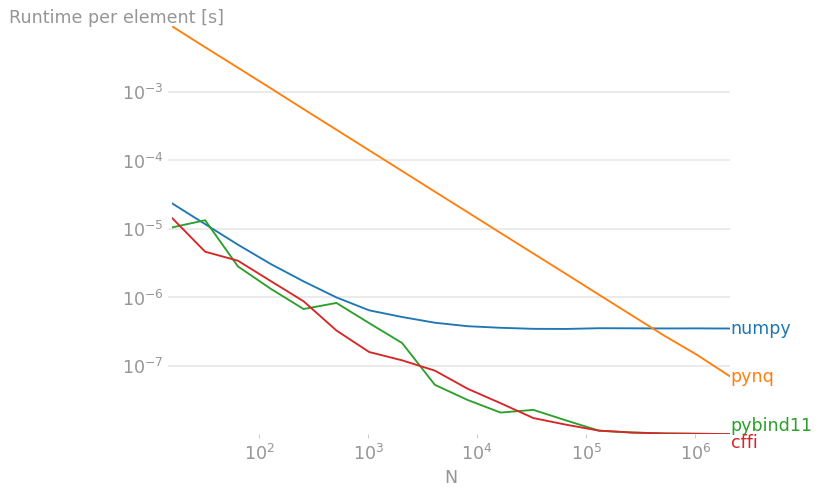

pynq_min = 262144
pybind11_min = 32
cffi_min = 0
Bitstream download time = 0.233724852


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.337684375e-05    │ 0.02355169354375… │ 0.01461828256875   │ 0.01462206125     │
│ 32      │ 1.169193125000000… │ 0.01175574227187… │ 0.00731721639375   │ 0.00730853195000… │
│ 64      │ 5.8564625e-06      │ 0.00588829903125… │ 0.0036547744046875 │ 0.00365536938125  │
│ 128     │ 3.06025234375e-06  │ 0.00294663655781… │ 0.001827306665625… │ 0.00182770151171… │
│ 256     │ 1.708525000000000… │ 0.00146975415742… │ 0.000913662347265… │ 0.00091386357695… │
│ 512     │ 9.968173828125001… │ 0.00073517008984… │ 0.000457321707226… │ 0.00045682206914… │
│ 1024    │ 6.456824218750001… │ 0.00036755750371… │ 0.000228666645410… │ 0.00022840597314… │
│ 2048    │ 5.16181494140625e… │ 0.00018379476972… │ 0.000114339188085… │ 0.00011424396005… │
│ 4096    │ 4.259096435546875… │ 9.18244788574218… │ 5.711458151855469… │ 5.71468894287109… │
│ 8192    │ 3.787371826171875… │ 4.59474170410156… │ 2.856261245117187… │ 2.85771642089843… │
│ 16384   │ 3.593248413085938… │ 2.29660352966308… │ 1.428626278686523… │ 1.42939862670898… │
│ 32768   │ 3.468655364990234… │ 1.14910731323242… │ 7.155503671264648… │ 7.15003836975097… │
│ 65536   │ 3.455970642089844… │ 5.75390473480224… │ 3.582346063232422… │ 3.58020451354980… │
│ 131072  │ 3.541894813537598… │ 2.87406050567626… │ 1.794503755950927… │ 1.79453765411376… │
│ 262144  │ 3.531600852966309… │ 1.43779103126525… │ 9.022566997528077… │ 9.02229090881347… │
│ 524288  │ 3.514112239837647… │ 7.19498234367370… │ 4.561232446670532… │ 4.56100450897216… │
│ 1048576 │ 3.522174372673035… │ 3.66426224994659… │ 2.330723134040832… │ 2.33145089912414… │
│ 2097152 │ 3.505423307895661… │ 1.81217994165420… │ 1.215391317844391… │ 1.21535810756683… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

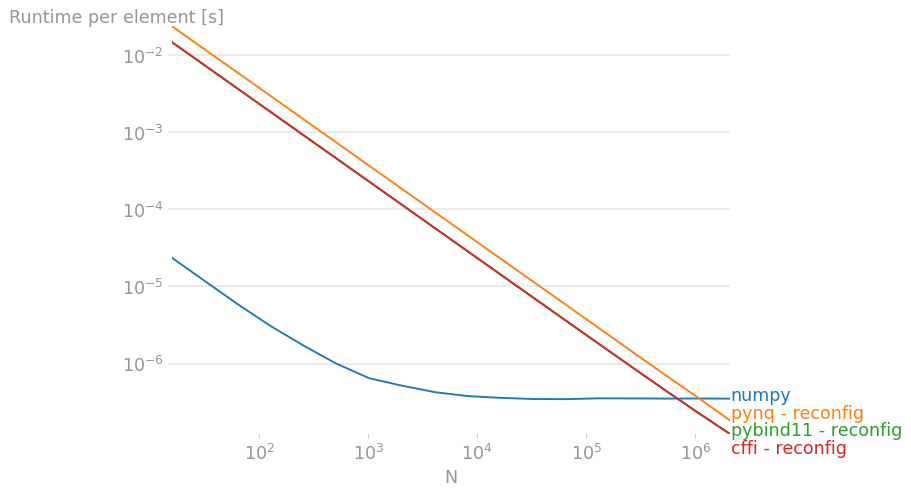

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    x2 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [add_call_f4_numpy, add_call_f4_pynq, add_call_f4_pybind11, add_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## subtract_call_f4


kernel = numpy, n = 16, t = 0.0003708126
kernel = pynq, n = 16, t = 0.1425504127
kernel = pybind11, n = 16, t = 0.00042864920000000004
kernel = cffi, n = 16, t = 0.00015015510000000002
kernel = numpy, n = 32, t = 0.0003625996
kernel = pynq, n = 32, t = 0.1422341351
kernel = pybind11, n = 32, t = 0.0004263086
kernel = cffi, n = 32, t = 0.00015070610000000002
kernel = numpy, n = 64, t = 0.00037150620000000003
kernel = pynq, n = 64, t = 0.14239790700000002
kernel = pybind11, n = 64, t = 0.000417593
kernel = cffi, n = 64, t = 0.00016255020000000003
kernel = numpy, n = 128, t = 0.00039617300000000004
kernel = pynq, n = 128, t = 0.142402137
kernel = pybind11, n = 128, t = 0.0004237828
kernel = cffi, n = 128, t = 0.0001536638
kernel = numpy, n = 256, t = 0.00044457420000000006
kernel = pynq, n = 256, t = 0.142237694
kernel = pybind11, n = 256, t = 0.00017482410000000003
kernel = cffi, n = 256, t = 0.00022505670000000003
kernel = numpy, n = 512, t = 0.0004962476
kernel = pynq, n = 512, t = 0.1

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.31757875e-05     │ 0.00890940079375  │ 2.679057500000000… │ 9.38469375000000… │
│ 32      │ 1.13312375e-05     │ 0.004444816721875 │ 1.332214375e-05    │ 4.70956562500000… │
│ 64      │ 5.804784375000000… │ 0.00222496729687… │ 6.524890625e-06    │ 2.53984687500000… │
│ 128     │ 3.095101562500000… │ 0.00111251669531… │ 3.310803125e-06    │ 1.2004984375e-06  │
│ 256     │ 1.736617968750000… │ 0.00055561599218… │ 6.829066406250001… │ 8.79127734375000… │
│ 512     │ 9.6923359375e-07   │ 0.00027811362148… │ 8.282240234375001… │ 3.328875e-07      │
│ 1024    │ 6.432208984375e-07 │ 0.00013934389707… │ 1.786337890625e-07 │ 2.26077636718750… │
│ 2048    │ 5.133978515625e-07 │ 6.95930359375e-05 │ 2.15176806640625e… │ 1.26017431640625… │
│ 4096    │ 4.288121093750000… │ 3.47932524169921… │ 5.3570458984375e-… │ 8.45137451171875… │
│ 8192    │ 3.780487060546875… │ 1.7428402734375e… │ 3.155712890625000… │ 4.58848022460937… │
│ 16384   │ 3.592459411621094… │ 8.70888591918945… │ 2.10514404296875e… │ 2.80652099609375… │
│ 32768   │ 3.472636810302735… │ 4.38408283081054… │ 1.534119567871093… │ 1.83555053710937… │
│ 65536   │ 3.559888824462891… │ 2.17965236968994… │ 1.595870819091797… │ 1.38314117431640… │
│ 131072  │ 3.429009300231934… │ 1.09231662979125… │ 1.251526489257812… │ 1.14465866088867… │
│ 262144  │ 3.536245155334473… │ 5.45949175643920… │ 1.071927337646484… │ 1.06254695892333… │
│ 524288  │ 3.515527793884277… │ 2.73251183700561… │ 1.035806865692138… │ 1.03077644348144… │
│ 1048576 │ 3.514770396232605… │ 1.37985142898559… │ 1.017639474868774… │ 1.01934840202331… │
│ 2097152 │ 3.500073006629944… │ 6.97249192714691… │ 1.008926491737365… │ 1.00866935253143… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

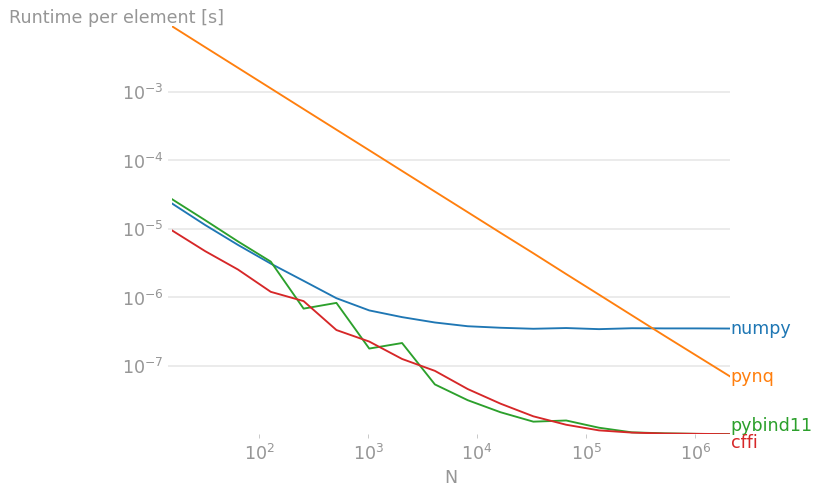

pynq_min = 262144
pybind11_min = 128
cffi_min = 0
Bitstream download time = 0.221848541


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.31757875e-05     │ 0.02277493460625  │ 0.0138923243875    │ 0.01387491850625  │
│ 32      │ 1.13312375e-05     │ 0.011377583628125 │ 0.006946089050000… │ 0.00693747647187… │
│ 64      │ 5.804784375000000… │ 0.00569135075000… │ 0.00347290834375   │ 0.0034689233      │
│ 128     │ 3.095101562500000… │ 0.002845708421875 │ 0.0017365025296875 │ 0.00173439222500… │
│ 256     │ 1.736617968750000… │ 0.00142221185546… │ 0.000867278769921… │ 0.00086747499101… │
│ 512     │ 9.6923359375e-07   │ 0.000711411553125 │ 0.000434126155664… │ 0.00043363081914… │
│ 1024    │ 6.432208984375e-07 │ 0.00035599286289… │ 0.000216827599609… │ 0.00021687504345… │
│ 2048    │ 5.133978515625e-07 │ 0.00017791751884… │ 0.000108539659716… │ 0.00010845050034… │
│ 4096    │ 4.288121093750000… │ 8.89554938720703… │ 5.42158119140625e… │ 5.42467552001953… │
│ 8192    │ 3.780487060546875… │ 4.45095234619140… │ 2.711267785644531… │ 2.71270055297851… │
│ 16384   │ 3.592459411621094… │ 2.22494462829589… │ 1.356161180419921… │ 1.35686255737304… │
│ 32768   │ 3.472636810302735… │ 1.11543630126953… │ 6.785621377563477… │ 6.78863568725586… │
│ 65536   │ 3.559888824462891… │ 5.56479246063232… │ 3.401098799133301… │ 3.39897150268554… │
│ 131072  │ 3.429009300231934… │ 2.78488667526245… │ 1.705085310363769… │ 1.70401663208007… │
│ 262144  │ 3.536245155334473… │ 1.39223419837951… │ 8.570042961120606… │ 8.56910492324829… │
│ 524288  │ 3.515527793884277… │ 6.96393695068359… │ 4.335005800247193… │ 4.33450275802612… │
│ 1048576 │ 3.514770396232605… │ 3.49556398582458… │ 2.217476504325866… │ 2.21764739704132… │
│ 2097152 │ 3.500073006629944… │ 1.75510547113418… │ 1.158748927593231… │ 1.15872321367263… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

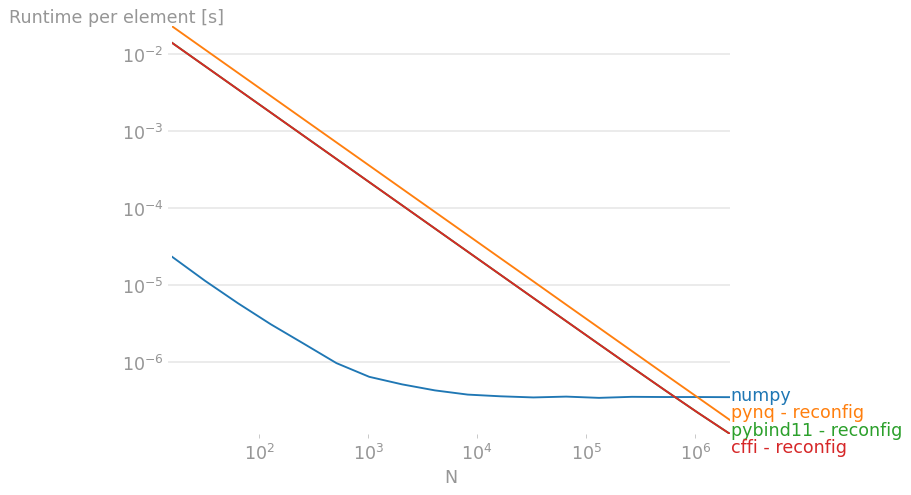

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [11]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    x2 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [subtract_call_f4_numpy, subtract_call_f4_pynq, subtract_call_f4_pybind11, subtract_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## multiply_call_f4


kernel = numpy, n = 16, t = 0.0003664437
kernel = pynq, n = 16, t = 0.1432808361
kernel = pybind11, n = 16, t = 0.00041879010000000003
kernel = cffi, n = 16, t = 0.00014966220000000002
kernel = numpy, n = 32, t = 0.000370948
kernel = pynq, n = 32, t = 0.14392533180000003
kernel = pybind11, n = 32, t = 0.0004141111
kernel = cffi, n = 32, t = 0.00016138370000000002
kernel = numpy, n = 64, t = 0.0003689138
kernel = pynq, n = 64, t = 0.1434189256
kernel = pybind11, n = 64, t = 0.00041739170000000005
kernel = cffi, n = 64, t = 0.0001514938
kernel = numpy, n = 128, t = 0.00039908950000000005
kernel = pynq, n = 128, t = 0.143277237
kernel = pybind11, n = 128, t = 0.00018305410000000002
kernel = cffi, n = 128, t = 0.0002220655
kernel = numpy, n = 256, t = 0.0004321637
kernel = pynq, n = 256, t = 0.1431670019
kernel = pybind11, n = 256, t = 0.0004426883
kernel = cffi, n = 256, t = 0.00015584310000000003
kernel = numpy, n = 512, t = 0.0004967741
kernel = pynq, n = 512, t = 0.1431540401
kernel = 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.290273125e-05    │ 0.00895505225625  │ 2.617438125000000… │ 9.35388750000000… │
│ 32      │ 1.1592125e-05      │ 0.00449766661875… │ 1.2940971875e-05   │ 5.04324062500000… │
│ 64      │ 5.764278125e-06    │ 0.0022409207125   │ 6.521745312500001… │ 2.367090625e-06   │
│ 128     │ 3.117886718750000… │ 0.00111935341406… │ 1.430110156250000… │ 1.73488671875e-06 │
│ 256     │ 1.688139453125e-06 │ 0.00055924610117… │ 1.729251171875e-06 │ 6.08762109375000… │
│ 512     │ 9.702619140625e-07 │ 0.00027959773457… │ 3.432726562500000… │ 4.43141015625000… │
│ 1024    │ 6.476736328125001… │ 0.00013984513466… │ 4.210576171875000… │ 2.3379501953125e… │
│ 2048    │ 5.180106445312501… │ 7.00463598632812… │ 2.2043583984375e-… │ 1.20117626953125… │
│ 4096    │ 4.28680224609375e… │ 3.49381977539062… │ 5.283828125000001… │ 8.35281005859375… │
│ 8192    │ 3.780176879882812… │ 1.754068984375e-… │ 3.181054687500000… │ 4.59671020507812… │
│ 16384   │ 3.593003662109375… │ 8.73873571166992… │ 2.212725219726562… │ 2.73585632324218… │
│ 32768   │ 3.473198516845703… │ 4.36795380249023… │ 2.145636596679687… │ 1.72049743652343… │
│ 65536   │ 3.464864166259766… │ 2.19480109710693… │ 1.597881164550781… │ 1.38952453613281… │
│ 131072  │ 3.433832069396973… │ 1.09755180587768… │ 1.254739379882812… │ 1.14386878967285… │
│ 262144  │ 3.537072700500488… │ 5.50225134277343… │ 1.068305015563964… │ 1.06134689331054… │
│ 524288  │ 3.522627624511718… │ 2.74846026802063… │ 1.033290119171142… │ 1.03253280639648… │
│ 1048576 │ 3.513156207084656… │ 1.39521950149536… │ 1.016900930404663… │ 1.01703831672668… │
│ 2097152 │ 3.502283091545105… │ 7.00834380626678… │ 1.008550024032592… │ 1.00899675846099… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

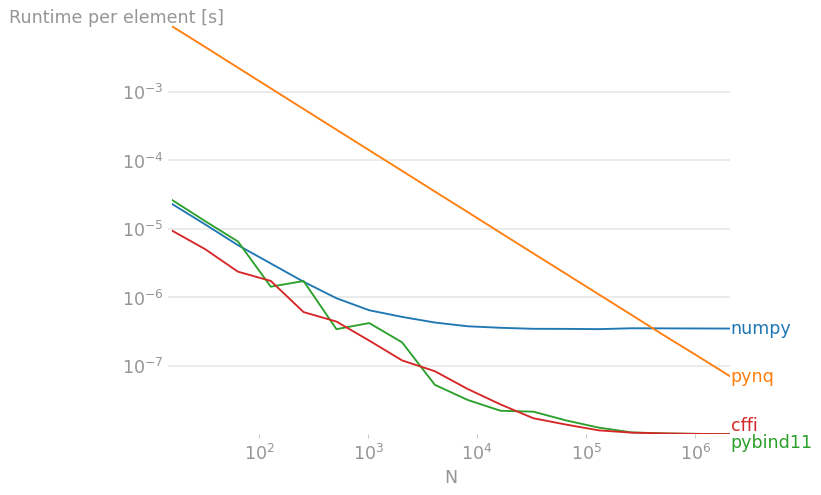

pynq_min = 262144
pybind11_min = 256
cffi_min = 0
Bitstream download time = 0.219320234


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.290273125e-05    │ 0.02266256688125  │ 0.01373368900625   │ 0.01371686851250… │
│ 32      │ 1.1592125e-05      │ 0.01135142393125  │ 0.006866698284375  │ 0.006858800553125 │
│ 64      │ 5.764278125e-06    │ 0.00566779936875  │ 0.0034334004015625 │ 0.00342924574687… │
│ 128     │ 3.117886718750000… │ 0.00283279274218… │ 0.001714869438281… │ 0.00171517421484… │
│ 256     │ 1.688139453125e-06 │ 0.00141596576523… │ 0.000858448915234… │ 0.00085732842617… │
│ 512     │ 9.702619140625e-07 │ 0.00070795756660… │ 0.0004287031046875 │ 0.00042880297304… │
│ 1024    │ 6.476736328125001… │ 0.00035402505068… │ 0.000214600973632… │ 0.00021441371103… │
│ 2048    │ 5.180106445312501… │ 0.00017713631787… │ 0.000107310393847… │ 0.00010721007563… │
│ 4096    │ 4.28680224609375e… │ 8.84831767578125… │ 5.359781728515625… │ 5.36285071044921… │
│ 8192    │ 3.780176879882812… │ 4.43131793457031… │ 2.680430004882812… │ 2.68184566040039… │
│ 16384   │ 3.593003662109375… │ 2.21249804626464… │ 1.340837200317382… │ 1.34136033142089… │
│ 32768   │ 3.473198516845703… │ 1.10610761779785… │ 6.714578741455078… │ 6.71032734985351… │
│ 65536   │ 3.464864166259766… │ 5.54136228485107… │ 3.362539999389648… │ 3.36045643310546… │
│ 131072  │ 3.433832069396973… │ 2.77083239974975… │ 1.685827987670898… │ 1.68471928176879… │
│ 262144  │ 3.537072700500488… │ 1.38686543121337… │ 8.473233470916748… │ 8.47253765869140… │
│ 524288  │ 3.522627624511718… │ 6.93166175270080… │ 4.28653049659729e… │ 4.28645476531982… │
│ 1048576 │ 3.513156207084656… │ 3.48682024383544… │ 2.193290835380554… │ 2.19330457401275… │
│ 2097152 │ 3.502283091545105… │ 1.74663475179672… │ 1.146655373573303… │ 1.14670004701614… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

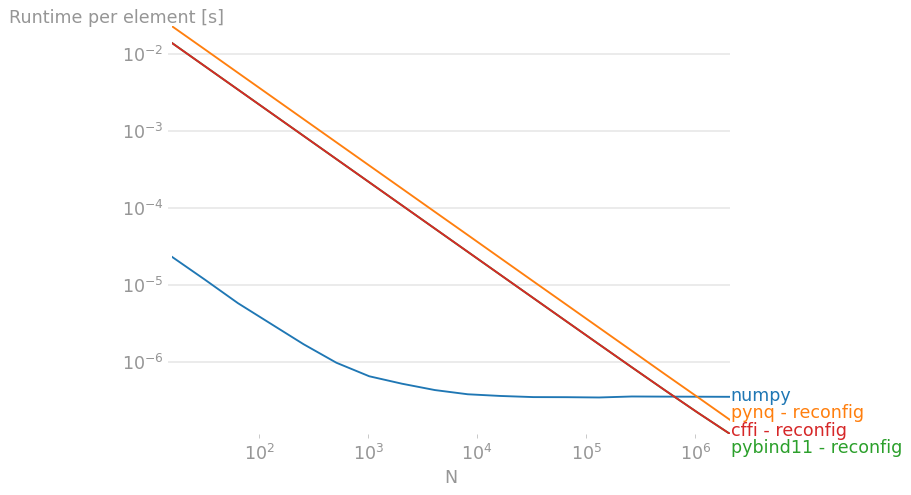

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [12]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    x2 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [multiply_call_f4_numpy, multiply_call_f4_pynq, multiply_call_f4_pybind11, multiply_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## true_divide_call_f4


kernel = numpy, n = 16, t = 0.0003540808
kernel = pynq, n = 16, t = 0.14370065640000002
kernel = pybind11, n = 16, t = 0.00017907290000000002
kernel = cffi, n = 16, t = 0.00021356790000000002
kernel = numpy, n = 32, t = 0.0003743527
kernel = pynq, n = 32, t = 0.1436738093
kernel = pybind11, n = 32, t = 0.00017036920000000004
kernel = cffi, n = 32, t = 0.00023334920000000003
kernel = numpy, n = 64, t = 0.0003737256
kernel = pynq, n = 64, t = 0.14370789030000003
kernel = pybind11, n = 64, t = 0.0001730222
kernel = cffi, n = 64, t = 0.0002217779
kernel = numpy, n = 128, t = 0.00039150780000000003
kernel = pynq, n = 128, t = 0.14361074380000002
kernel = pybind11, n = 128, t = 0.00042138960000000003
kernel = cffi, n = 128, t = 0.0001650431
kernel = numpy, n = 256, t = 0.00044747680000000004
kernel = pynq, n = 256, t = 0.14362190800000002
kernel = pybind11, n = 256, t = 0.00043499500000000003
kernel = cffi, n = 256, t = 0.0001563981
kernel = numpy, n = 512, t = 0.0005090436
kernel = pynq, n 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.213005e-05       │ 0.00898129102500… │ 1.119205625000000… │ 1.33479937500000… │
│ 32      │ 1.1698521875e-05   │ 0.004489806540625 │ 5.324037500000001… │ 7.29216250000000… │
│ 64      │ 5.8394625e-06      │ 0.00224543578593… │ 2.703471875e-06    │ 3.4652796875e-06  │
│ 128     │ 3.058654687500000… │ 0.00112195893593… │ 3.292106250000000… │ 1.28939921875e-06 │
│ 256     │ 1.747956250000000… │ 0.00056102307812… │ 1.699199218750000… │ 6.10930078125e-07 │
│ 512     │ 9.9422578125e-07   │ 0.00028058903125  │ 8.551392578125e-07 │ 3.10426562500000… │
│ 1024    │ 6.5648017578125e-… │ 0.00014056129375… │ 4.365829101562500… │ 1.62858203125e-07 │
│ 2048    │ 5.3522998046875e-… │ 7.02665990234375… │ 2.1559990234375e-… │ 1.2084462890625e… │
│ 4096    │ 4.443853759765625… │ 3.50427624267578… │ 1.152449707031250… │ 6.41557373046875… │
│ 8192    │ 3.964663085937500… │ 1.75976692138671… │ 3.177907714843750… │ 4.54387695312500… │
│ 16384   │ 3.771255798339844… │ 8.77170543823242… │ 3.615818481445312… │ 2.75838684082031… │
│ 32768   │ 3.656000854492187… │ 4.41153038024902… │ 1.559322509765625… │ 1.73069854736328… │
│ 65536   │ 3.627597183227539… │ 2.19954655303955… │ 1.591685485839843… │ 1.37532958984375… │
│ 131072  │ 3.725602630615234… │ 1.10102957763671… │ 1.141011199951171… │ 1.1384716796875e… │
│ 262144  │ 3.712028701782227… │ 5.51468357086181… │ 1.070810432434082… │ 1.06118225097656… │
│ 524288  │ 3.699836967468262… │ 2.76067965698242… │ 1.035468654632568… │ 1.03190971374511… │
│ 1048576 │ 3.686555736541748… │ 1.39431529521942… │ 1.017225379943847… │ 1.01731302261352… │
│ 2097152 │ 3.69088067483902e… │ 7.23345883369445… │ 1.013891954421997… │ 1.00876337051391… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

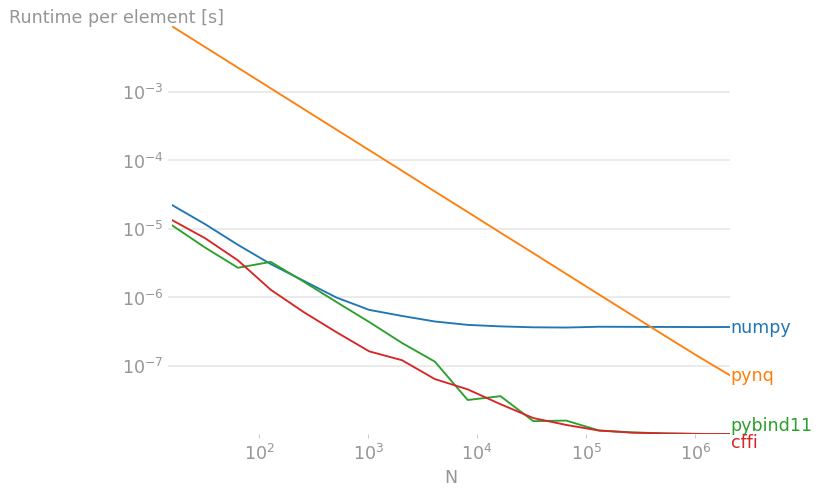

pynq_min = 262144
pybind11_min = 128
cffi_min = 0
Bitstream download time = 0.218087889


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.213005e-05       │ 0.02261178408750… │ 0.01364168511875   │ 0.01364384105625  │
│ 32      │ 1.1698521875e-05   │ 0.01130505307187… │ 0.00682057056875   │ 0.00682253869375… │
│ 64      │ 5.8394625e-06      │ 0.00565305905156… │ 0.003410326737500… │ 0.00341108854531… │
│ 128     │ 3.058654687500000… │ 0.00282577056875… │ 0.0017071037390625 │ 0.00170510103203… │
│ 256     │ 1.747956250000000… │ 0.00141292889453… │ 0.000853605015625  │ 0.00085251674648… │
│ 512     │ 9.9422578125e-07   │ 0.00070654193945… │ 0.000426808047460… │ 0.00042626333476… │
│ 1024    │ 6.5648017578125e-… │ 0.00035353774785… │ 0.000213413037011… │ 0.00021313931230… │
│ 2048    │ 5.3522998046875e-… │ 0.00017675482607… │ 0.000106703826953… │ 0.00010660907167… │
│ 4096    │ 4.443853759765625… │ 8.82868759521484… │ 5.335935849609375… │ 5.33082692626953… │
│ 8192    │ 3.964663085937500… │ 4.42197259765625… │ 2.665383583984375… │ 2.66674955322265… │
│ 16384   │ 3.771255798339844… │ 2.20827338195800… │ 1.334718656616210… │ 1.33386122497558… │
│ 32768   │ 3.656000854492187… │ 1.10670445709228… │ 6.671107415771484… │ 6.67282117614746… │
│ 65536   │ 3.627597183227539… │ 5.52730364837646… │ 3.343673950195312… │ 3.34151039123535… │
│ 131072  │ 3.725602630615234… │ 2.76490812530517… │ 1.675288659667968… │ 1.67526326446533… │
│ 262144  │ 3.712028701782227… │ 1.38340763092041… │ 8.426473781585693… │ 8.42551096343994… │
│ 524288  │ 3.699836967468262… │ 6.92037602615356… │ 4.2632432346344e-… │ 4.26288734054565… │
│ 1048576 │ 3.686555736541748… │ 3.47416347980499… │ 2.181570722579956… │ 2.18157948684692… │
│ 2097152 │ 3.69088067483902e… │ 1.76326997566223… │ 1.141313287734985… │ 1.14080042934417… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

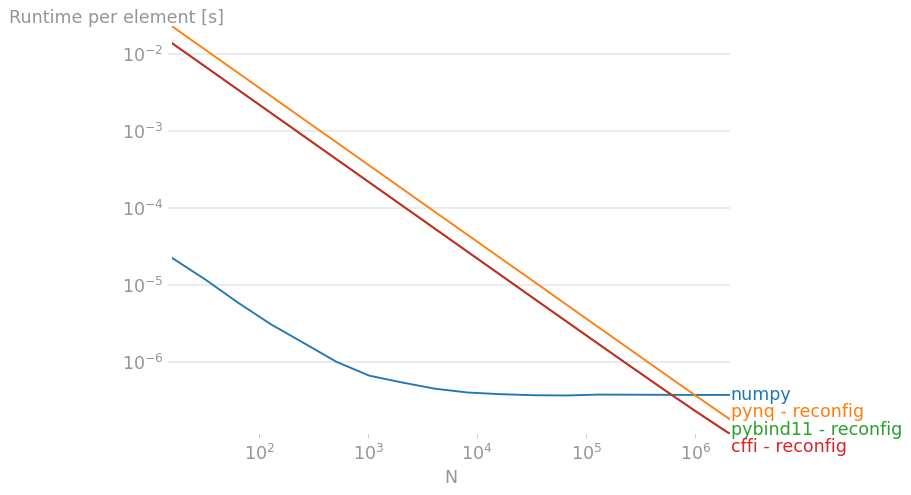

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [13]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    x2 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    x2[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, x2, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [true_divide_call_f4_numpy, true_divide_call_f4_pynq, true_divide_call_f4_pybind11, true_divide_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sin_call_f4


kernel = numpy, n = 16, t = 0.0003674215
kernel = pynq, n = 16, t = 0.1193717672
kernel = pybind11, n = 16, t = 0.0004094775
kernel = cffi, n = 16, t = 0.0001412418
kernel = numpy, n = 32, t = 0.00033703330000000003
kernel = pynq, n = 32, t = 0.12017915430000001
kernel = pybind11, n = 32, t = 0.0004104523
kernel = cffi, n = 32, t = 0.00015327600000000001
kernel = numpy, n = 64, t = 0.00034503040000000005
kernel = pynq, n = 64, t = 0.1192965995
kernel = pybind11, n = 64, t = 0.0004119941
kernel = cffi, n = 64, t = 0.00015381810000000002
kernel = numpy, n = 128, t = 0.0003661803
kernel = pynq, n = 128, t = 0.11948496690000002
kernel = pybind11, n = 128, t = 0.00016065720000000002
kernel = cffi, n = 128, t = 0.0002143055
kernel = numpy, n = 256, t = 0.00042596400000000003
kernel = pynq, n = 256, t = 0.11940430940000002
kernel = pybind11, n = 256, t = 0.0004384616
kernel = cffi, n = 256, t = 0.00014753270000000002
kernel = numpy, n = 512, t = 0.0004831963
kernel = pynq, n = 512, t = 0.1194

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.296384375e-05    │ 0.00746073545     │ 2.559234375e-05    │ 8.8276125e-06     │
│ 32      │ 1.053229062500000… │ 0.00375559857187… │ 1.2826634375e-05   │ 4.78987500000000… │
│ 64      │ 5.391100000000001… │ 0.00186400936718… │ 6.4374078125e-06   │ 2.40340781250000… │
│ 128     │ 2.86078359375e-06  │ 0.00093347630390… │ 1.255134375000000… │ 1.67426171875e-06 │
│ 256     │ 1.663921875000000… │ 0.00046642308359… │ 1.712740625e-06    │ 5.76299609375000… │
│ 512     │ 9.437427734375e-07 │ 0.00023336062167… │ 3.268517578125e-07 │ 4.41957421875000… │
│ 1024    │ 6.477220703125001… │ 0.00011654216757… │ 4.240423828125000… │ 1.515037109375e-… │
│ 2048    │ 4.698966308593750… │ 5.8363557421875e… │ 2.187693847656250… │ 1.1576845703125e… │
│ 4096    │ 3.925280761718750… │ 2.90695284423828… │ 5.060869140625001… │ 7.960537109375e-… │
│ 8192    │ 3.482556396484375… │ 1.45885827636718… │ 5.994136962890625… │ 3.65677734375000… │
│ 16384   │ 3.306238159179687… │ 7.30022484130859… │ 3.517545776367187… │ 2.74123168945312… │
│ 32768   │ 3.182865447998047… │ 3.63769789733886… │ 2.250152893066406… │ 1.79905731201171… │
│ 65536   │ 3.188436889648438… │ 1.82908689270019… │ 1.554434509277344… │ 1.35225036621093… │
│ 131072  │ 3.264535064697266… │ 9.16561047363281… │ 1.220104446411132… │ 1.12538024902343… │
│ 262144  │ 3.261249969482422… │ 4.57424635696411… │ 1.062149696350097… │ 1.05798244476318… │
│ 524288  │ 3.248267805099487… │ 2.31084519195556… │ 1.033725204467773… │ 1.02949295043945… │
│ 1048576 │ 3.281306062698364… │ 1.15312175273895… │ 1.015993413925170… │ 1.01643057823181… │
│ 2097152 │ 3.287146702766419… │ 5.81791245937347… │ 1.008377475738525… │ 1.00817951679229… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

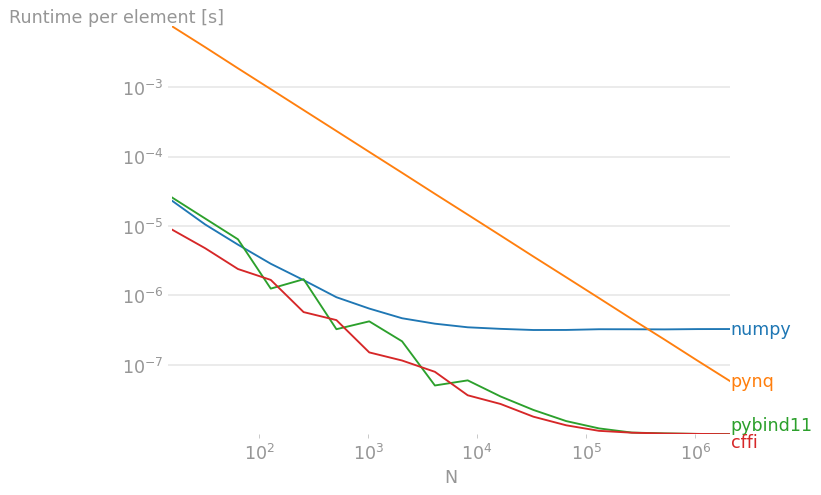

pynq_min = 262144
pybind11_min = 256
cffi_min = 0
Bitstream download time = 0.21883781800000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.296384375e-05    │ 0.021138099075    │ 0.013702955968750… │ 0.01368619123750… │
│ 32      │ 1.053229062500000… │ 0.01059428038437… │ 0.006851508446875… │ 0.00684347168750… │
│ 64      │ 5.391100000000001… │ 0.00528335027343… │ 0.003425778314062… │ 0.00342174431406… │
│ 128     │ 2.86078359375e-06  │ 0.00264314675703… │ 0.001710925587500… │ 0.00171134471484… │
│ 256     │ 1.663921875000000… │ 0.00132125831015… │ 0.0008565479671875 │ 0.00085541152617… │
│ 512     │ 9.437427734375e-07 │ 0.00066077823496… │ 0.000427744465039… │ 0.00042785957070… │
│ 1024    │ 6.477220703125001… │ 0.00033025097421… │ 0.000214132849023… │ 0.00021386031035… │
│ 2048    │ 4.698966308593750… │ 0.00016521796074… │ 0.000107073172705… │ 0.00010697017177… │
│ 4096    │ 3.925280761718750… │ 8.24967301025390… │ 5.347781035156251… │ 5.35068070312500… │
│ 8192    │ 3.482556396484375… │ 4.13021835937500… │ 2.677354219970703… │ 2.67501686035156… │
│ 16384   │ 3.306238159179687… │ 2.06570252563476… │ 1.339197587280273… │ 1.33842127319335… │
│ 32768   │ 3.182865447998047… │ 1.03160981048583… │ 6.700901736450195… │ 6.69639078063964… │
│ 65536   │ 3.188436889648438… │ 5.16828699645996… │ 3.354744448852539… │ 3.35272260742187… │
│ 131072  │ 3.264535064697266… │ 2.58616109924316… │ 1.681801096343994… │ 1.68085385437011… │
│ 262144  │ 3.261249969482422… │ 1.29222466163635… │ 8.454215229034424… │ 8.45379850387573… │
│ 524288  │ 3.248267805099487… │ 6.48484532165527… │ 4.277372650146484… │ 4.27694942474365… │
│ 1048576 │ 3.281306062698364… │ 3.24012181758880… │ 2.188599406242370… │ 2.18864312267303… │
│ 2097152 │ 3.287146702766419… │ 1.62529127836227… │ 1.144337779998779… │ 1.14431798410415… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

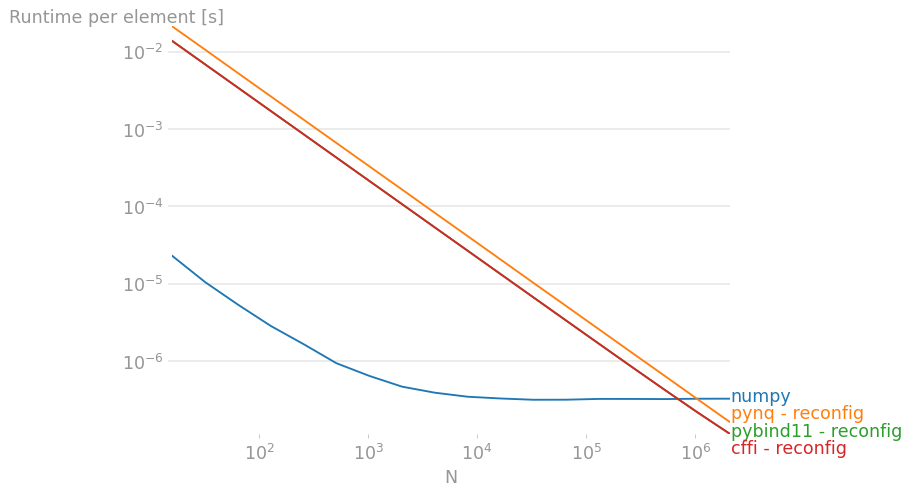

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [14]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sin_call_f4_numpy, sin_call_f4_pynq, sin_call_f4_pybind11, sin_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sqrt_call_f4


kernel = numpy, n = 16, t = 0.00032407720000000005
kernel = pynq, n = 16, t = 0.1194777571
kernel = pybind11, n = 16, t = 0.0004079535
kernel = cffi, n = 16, t = 0.0001408582
kernel = numpy, n = 32, t = 0.0003454425
kernel = pynq, n = 32, t = 0.1187615773
kernel = pybind11, n = 32, t = 0.00015610150000000002
kernel = cffi, n = 32, t = 0.0002092708
kernel = numpy, n = 64, t = 0.0003307345
kernel = pynq, n = 64, t = 0.11900991770000001
kernel = pybind11, n = 64, t = 0.00041396740000000003
kernel = cffi, n = 64, t = 0.0001417003
kernel = numpy, n = 128, t = 0.0003372366
kernel = pynq, n = 128, t = 0.1191305383
kernel = pybind11, n = 128, t = 0.0004219348
kernel = cffi, n = 128, t = 0.0001438397
kernel = numpy, n = 256, t = 0.0003683757
kernel = pynq, n = 256, t = 0.11912161390000002
kernel = pybind11, n = 256, t = 0.0004124676
kernel = cffi, n = 256, t = 0.0001454714
kernel = numpy, n = 512, t = 0.0003850082
kernel = pynq, n = 512, t = 0.11916202190000001
kernel = pybind11, n = 512, t = 0

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.025482500000000… │ 0.00746735981875  │ 2.549709375e-05    │ 8.8036375e-06     │
│ 32      │ 1.0795078125e-05   │ 0.003711299290625 │ 4.878171875000001… │ 6.5397125e-06     │
│ 64      │ 5.1677265625e-06   │ 0.00185952996406… │ 6.468240625000000… │ 2.2140671875e-06  │
│ 128     │ 2.6346609375e-06   │ 0.00093070733046… │ 3.296365625e-06    │ 1.12374765625e-06 │
│ 256     │ 1.438967578125e-06 │ 0.00046531880429… │ 1.6112015625e-06   │ 5.6824765625e-07  │
│ 512     │ 7.51969140625e-07  │ 0.00023273832402… │ 3.279505859375000… │ 4.26339453125e-07 │
│ 1024    │ 4.2460634765625e-… │ 0.00011631373232… │ 4.1022685546875e-… │ 1.51882519531250… │
│ 2048    │ 2.6004072265625e-… │ 5.81679281250000… │ 2.15261279296875e… │ 8.003701171875e-… │
│ 4096    │ 1.695429443359375… │ 2.91083133300781… │ 1.129590576171875… │ 4.67622314453125… │
│ 8192    │ 1.286229370117187… │ 1.45623674682617… │ 3.021529541015625… │ 4.54440795898437… │
│ 16384   │ 1.095018371582031… │ 7.25819380493164… │ 2.840099487304688… │ 2.59210327148437… │
│ 32768   │ 9.886098022460939… │ 3.63974400329589… │ 2.239764709472656… │ 1.80823944091796… │
│ 65536   │ 9.361535186767579… │ 1.93611106262207… │ 1.567969360351562… │ 1.25163299560546… │
│ 131072  │ 1.147043632507324… │ 1.00633332901000… │ 1.222752304077148… │ 1.12288803100585… │
│ 262144  │ 1.057557903289794… │ 4.55748884582519… │ 1.067755889892578… │ 1.05807075500488… │
│ 524288  │ 1.039639696121215… │ 2.28412192344665… │ 1.033663997650146… │ 1.02889566421508… │
│ 1048576 │ 1.040778410911560… │ 1.15208757400512… │ 1.016483135223388… │ 1.02974005699157… │
│ 2097152 │ 1.042320066452026… │ 5.80009816169738… │ 1.017053561210632… │ 1.00814093112945… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

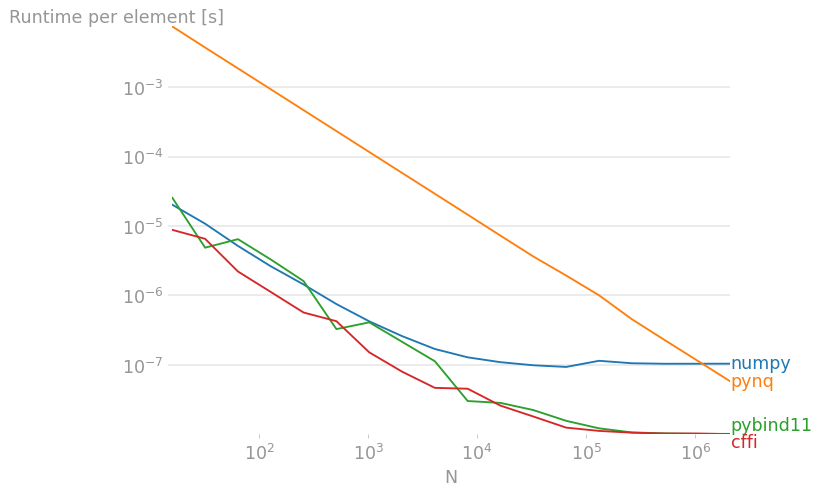

pynq_min = 1048576
pybind11_min = 256
cffi_min = 0
Bitstream download time = 0.22128723400000003


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.025482500000000… │ 0.02129781194375  │ 0.013855949218750… │ 0.01383925576250… │
│ 32      │ 1.0795078125e-05   │ 0.01062652535312… │ 0.006920104234375… │ 0.00692176577500… │
│ 64      │ 5.1677265625e-06   │ 0.00531714299531… │ 0.003464081271875… │ 0.00345982709843… │
│ 128     │ 2.6346609375e-06   │ 0.00265951384609… │ 0.001732102881250… │ 0.00172993026328… │
│ 256     │ 1.438967578125e-06 │ 0.00132972206210… │ 0.000866014459375… │ 0.00086497150546… │
│ 512     │ 7.51969140625e-07  │ 0.00066493995292… │ 0.000432529579492… │ 0.00043262796835… │
│ 1024    │ 4.2460634765625e-… │ 0.00033241454677… │ 0.000216511041308… │ 0.00021625269697… │
│ 2048    │ 2.6004072265625e-… │ 0.00016621833535… │ 0.000108265668505… │ 0.00010813044423… │
│ 4096    │ 1.695429443359375… │ 8.31335169433593… │ 5.413816267089844… │ 5.40719658447265… │
│ 8192    │ 1.286229370117187… │ 4.15749692749023… │ 2.704281710205078… │ 2.70580458862304… │
│ 16384   │ 1.095018371582031… │ 2.07644947082519… │ 1.353470189819336… │ 1.35322219360351… │
│ 32768   │ 9.886098022460939… │ 1.03928944549560… │ 6.775548098754884… │ 6.77123284606933… │
│ 65536   │ 9.361535186767579… │ 5.31268628845214… │ 3.392254919433594… │ 3.38909155578613… │
│ 131072  │ 1.147043632507324… │ 2.69462094192504… │ 1.700515135955810… │ 1.69951649322509… │
│ 262144  │ 1.057557903289794… │ 1.29989269104003… │ 8.548213653564454… │ 8.54724514007568… │
│ 524288  │ 1.039639696121215… │ 6.50484095573425… │ 4.324085432052613… │ 4.32360859870910… │
│ 1048576 │ 1.040778410911560… │ 3.26244709014892… │ 2.212007829666138… │ 2.21333352184295… │
│ 2097152 │ 1.042320066452026… │ 1.63518957424163… │ 1.156885114192962… │ 1.15599385118484… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

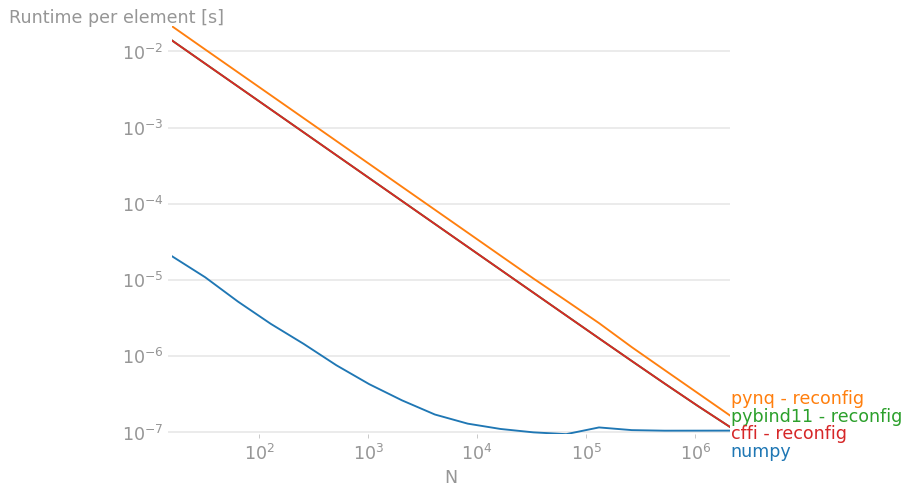

pynq_min_reconf = inf
pybind11_min_reconf = inf
cffi_min_reconf = inf


In [15]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sqrt_call_f4_numpy, sqrt_call_f4_pynq, sqrt_call_f4_pybind11, sqrt_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## arctan_call_f4


kernel = numpy, n = 16, t = 0.00034818450000000003
kernel = pynq, n = 16, t = 0.11979031920000001
kernel = pybind11, n = 16, t = 0.0004095707
kernel = cffi, n = 16, t = 0.00014178360000000002
kernel = numpy, n = 32, t = 0.000332928
kernel = pynq, n = 32, t = 0.1194753248
kernel = pybind11, n = 32, t = 0.00040671850000000004
kernel = cffi, n = 32, t = 0.0001528779
kernel = numpy, n = 64, t = 0.00034726440000000004
kernel = pynq, n = 64, t = 0.11939377870000001
kernel = pybind11, n = 64, t = 0.00040978840000000004
kernel = cffi, n = 64, t = 0.0001431438
kernel = numpy, n = 128, t = 0.0003825575
kernel = pynq, n = 128, t = 0.11938364220000001
kernel = pybind11, n = 128, t = 0.0004228031
kernel = cffi, n = 128, t = 0.0001436329
kernel = numpy, n = 256, t = 0.00043067530000000004
kernel = pynq, n = 256, t = 0.1194132682
kernel = pybind11, n = 256, t = 0.0004212403
kernel = cffi, n = 256, t = 0.0001455114
kernel = numpy, n = 512, t = 0.0004991674
kernel = pynq, n = 512, t = 0.119713945400000

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.176153125000000… │ 0.00748689495000… │ 2.559816875e-05    │ 8.86147500000000… │
│ 32      │ 1.0404e-05         │ 0.0037336039      │ 1.270995312500000… │ 4.777434375e-06   │
│ 64      │ 5.426006250000001… │ 0.00186552779218… │ 6.402943750000001… │ 2.236621875e-06   │
│ 128     │ 2.98873046875e-06  │ 0.00093268470468… │ 3.30314921875e-06  │ 1.12213203125e-06 │
│ 256     │ 1.682325390625000… │ 0.00046645807890… │ 1.645469921875e-06 │ 5.6840390625e-07  │
│ 512     │ 9.74936328125e-07  │ 0.00023381629960… │ 3.26437109375e-07  │ 4.275291015625e-… │
│ 1024    │ 6.8860205078125e-… │ 0.00011665372685… │ 1.691955078125e-07 │ 2.178025390625e-… │
│ 2048    │ 5.152130371093751… │ 5.83305338378906… │ 2.101426757812500… │ 8.021845703125e-… │
│ 4096    │ 4.3040458984375e-… │ 2.91531591308593… │ 1.126334228515625… │ 6.24944580078125… │
│ 8192    │ 3.8221484375e-07   │ 1.45867306396484… │ 5.94981201171875e… │ 3.56792358398437… │
│ 16384   │ 3.659144165039062… │ 7.29056924438476… │ 2.044099121093750… │ 2.68882141113281… │
│ 32768   │ 3.555422424316406… │ 3.64818383178710… │ 2.247507934570312… │ 1.81052520751953… │
│ 65536   │ 3.523994216918945… │ 1.82760804290771… │ 1.574985809326172… │ 1.36260284423828… │
│ 131072  │ 3.623059921264648… │ 9.18687500762939… │ 1.222802276611328… │ 1.12338981628417… │
│ 262144  │ 3.614549980163574… │ 4.57182862091064… │ 1.068111610412597… │ 1.05937572479248… │
│ 524288  │ 3.595725965499878… │ 2.30236502647399… │ 1.030957088470459… │ 1.03021129608154… │
│ 1048576 │ 3.594215419769287… │ 1.15513071632385… │ 1.016910724639892… │ 1.02657654762268… │
│ 2097152 │ 3.585636447429657… │ 5.80438950061798… │ 1.008288817405700… │ 1.00846282958984… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

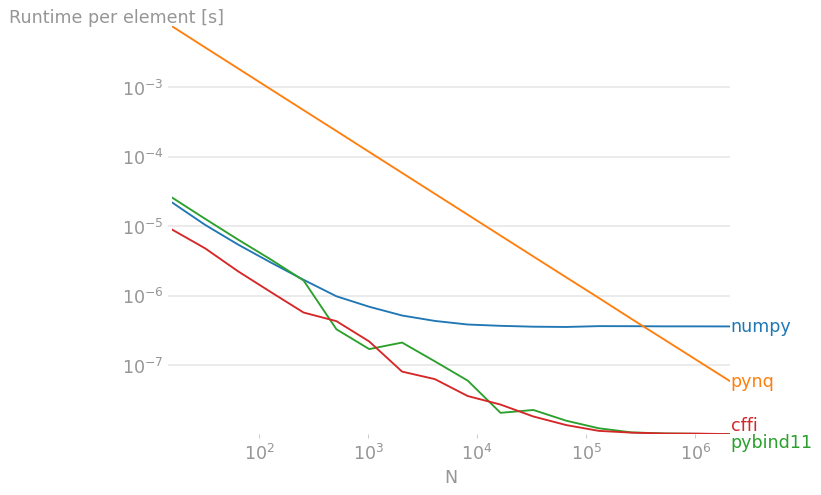

pynq_min = 262144
pybind11_min = 128
cffi_min = 0
Bitstream download time = 0.224675692


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.176153125000000… │ 0.02152912570000… │ 0.01406782891875   │ 0.014051092225    │
│ 32      │ 1.0404e-05         │ 0.01075471927500… │ 0.007033825328125  │ 0.007025892809375 │
│ 64      │ 5.426006250000001… │ 0.00537608547968… │ 0.00351696063125   │ 0.003512794309375 │
│ 128     │ 2.98873046875e-06  │ 0.00268796354843… │ 0.001758581992968… │ 0.00175640097578… │
│ 256     │ 1.682325390625000… │ 0.00134409750078… │ 0.000879284891796… │ 0.00087820782578… │
│ 512     │ 9.74936328125e-07  │ 0.00067263601054… │ 0.000439146148046… │ 0.00043924724003… │
│ 1024    │ 6.8860205078125e-… │ 0.00033606358232… │ 0.000219579050976… │ 0.00021962765800… │
│ 2048    │ 5.152130371093751… │ 0.00016803546157… │ 0.000109915070410… │ 0.00010978514619… │
│ 4096    │ 4.3040458984375e-… │ 8.40056229980468… │ 5.496509729003906… │ 5.49149583251953… │
│ 8192    │ 3.8221484375e-07   │ 4.20129625732421… │ 2.748573005371093… │ 2.74619111694335… │
│ 16384   │ 3.659144165039062… │ 2.10036852111816… │ 1.373355695800781… │ 1.37400041809082… │
│ 32768   │ 3.555422424316406… │ 1.05047418151855… │ 6.879033062744141… │ 6.87466323547363… │
│ 65536   │ 3.523994216918945… │ 5.25588703460693… │ 3.444028849792480… │ 3.44190502014160… │
│ 131072  │ 3.623059921264648… │ 2.63282699661254… │ 1.726367518615722… │ 1.72537339401245… │
│ 262144  │ 3.614549980163574… │ 1.31425261001586… │ 8.677508640289307… │ 8.67663505172729… │
│ 524288  │ 3.595725965499878… │ 6.58771376609802… │ 4.388444448471069… │ 4.38836986923217… │
│ 1048576 │ 3.594215419769287… │ 3.29780508613586… │ 2.244365442276001… │ 2.24533202457428… │
│ 2097152 │ 3.585636447429657… │ 1.65177613496780… │ 1.172166066646576… │ 1.17218346786499… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

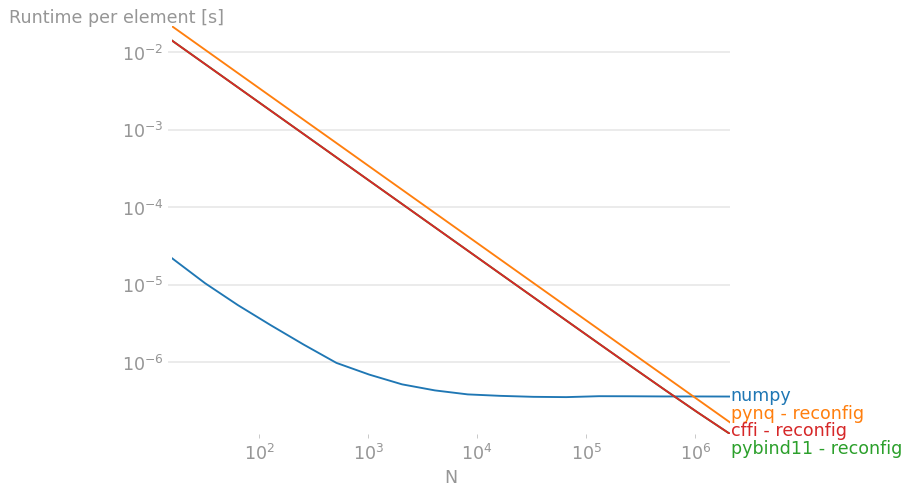

pynq_min_reconf = 524288
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [16]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [arctan_call_f4_numpy, arctan_call_f4_pynq, arctan_call_f4_pybind11, arctan_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## sinh_call_f4


kernel = numpy, n = 16, t = 0.0003383151
kernel = pynq, n = 16, t = 0.12036843670000001
kernel = pybind11, n = 16, t = 0.000406008
kernel = cffi, n = 16, t = 0.00015287540000000002
kernel = numpy, n = 32, t = 0.0003432485
kernel = pynq, n = 32, t = 0.1200806776
kernel = pybind11, n = 32, t = 0.00040763990000000004
kernel = cffi, n = 32, t = 0.00014141310000000002
kernel = numpy, n = 64, t = 0.0003581095
kernel = pynq, n = 64, t = 0.12012944870000002
kernel = pybind11, n = 64, t = 0.0005889261000000001
kernel = cffi, n = 64, t = 0.00028397990000000005
kernel = numpy, n = 128, t = 0.00039259540000000006
kernel = pynq, n = 128, t = 0.1253342174
kernel = pybind11, n = 128, t = 0.00016227970000000003
kernel = cffi, n = 128, t = 0.0002137093
kernel = numpy, n = 256, t = 0.00046586640000000003
kernel = pynq, n = 256, t = 0.1324939887
kernel = pybind11, n = 256, t = 0.0001787698
kernel = cffi, n = 256, t = 0.00021636300000000002
kernel = numpy, n = 512, t = 0.0005897824000000001
kernel = pynq,

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.114469375e-05    │ 0.00752302729375… │ 2.53755e-05        │ 9.55471250000000… │
│ 32      │ 1.0726515625e-05   │ 0.003752521175    │ 1.273874687500000… │ 4.41915937500000… │
│ 64      │ 5.5954609375e-06   │ 0.00187702263593… │ 9.201970312500001… │ 4.43718593750000… │
│ 128     │ 3.067151562500000… │ 0.00097917357343… │ 1.267810156250000… │ 1.66960390625e-06 │
│ 256     │ 1.819790625000000… │ 0.00051755464335… │ 6.9831953125e-07   │ 8.45167968750000… │
│ 512     │ 1.151918750000000… │ 0.00025152471777… │ 3.275828125e-07    │ 4.48133789062500… │
│ 1024    │ 8.448685546875e-07 │ 0.00011738974589… │ 4.216919921875e-07 │ 1.521736328125e-… │
│ 2048    │ 6.67683740234375e… │ 5.85571713378906… │ 9.019467773437501… │ 1.13625439453125… │
│ 4096    │ 5.894641845703125… │ 2.93498304931640… │ 8.394780273437501… │ 7.6480712890625e… │
│ 8192    │ 5.419214111328126… │ 1.47347533081054… │ 3.053740234375000… │ 4.55084350585937… │
│ 16384   │ 5.272041381835937… │ 7.33267045288086… │ 3.500734252929688… │ 2.73975158691406… │
│ 32768   │ 5.15042349243164e… │ 3.67489880676269… │ 2.194836425781250… │ 1.82677185058593… │
│ 65536   │ 5.138431243896485… │ 1.83751269226074… │ 1.557977142333984… │ 1.35418045043945… │
│ 131072  │ 5.115202865600586… │ 9.20145433807373… │ 1.136685485839843… │ 1.15076316833496… │
│ 262144  │ 5.23218014907837e… │ 4.59918625640869… │ 1.072584228515625… │ 1.05767051696777… │
│ 524288  │ 5.219141819000245… │ 2.30331845283508… │ 1.033261203765869… │ 1.02908798217773… │
│ 1048576 │ 5.214741751670838… │ 1.15877446556091… │ 1.016389408111572… │ 1.02559578895568… │
│ 2097152 │ 5.208662762641907… │ 5.84346734523773… │ 1.028574376106262… │ 1.00826951980590… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

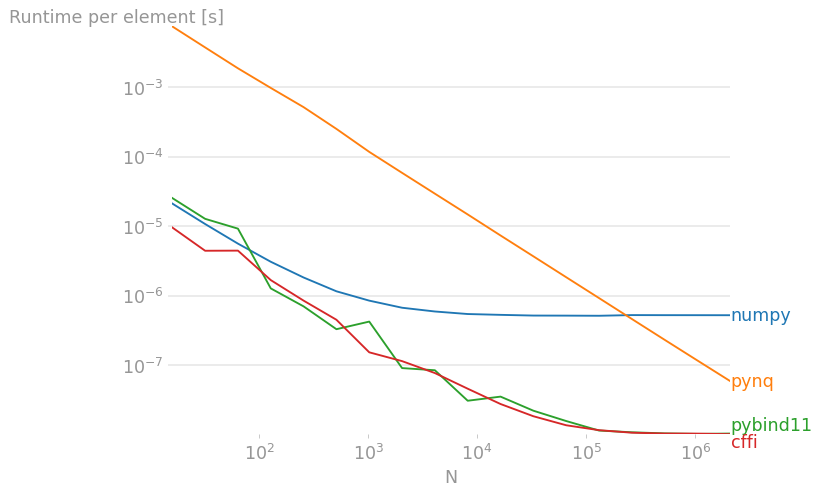

pynq_min = 131072
pybind11_min = 64
cffi_min = 0
Bitstream download time = 0.21711950700000002


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.114469375e-05    │ 0.02109299648125  │ 0.013595344687500… │ 0.01357952390000… │
│ 32      │ 1.0726515625e-05   │ 0.01053750576875  │ 0.006797723340625… │ 0.006789403753125 │
│ 64      │ 5.5954609375e-06   │ 0.00526951493281… │ 0.003401694267187… │ 0.00339692948281… │
│ 128     │ 3.067151562500000… │ 0.002675419721875 │ 0.001697513958593… │ 0.00169791575234… │
│ 256     │ 1.819790625000000… │ 0.00136567771757… │ 0.000848821393750… │ 0.00084896824218… │
│ 512     │ 1.151918750000000… │ 0.00067558625488… │ 0.000424389119921… │ 0.00042450967089… │
│ 1024    │ 8.448685546875e-07 │ 0.00032942051445… │ 0.000212452460546… │ 0.00021218294218… │
│ 2048    │ 6.67683740234375e… │ 0.00016457255561… │ 0.000106105578955… │ 0.00010612900971… │
│ 4096    │ 5.894641845703125… │ 8.23575226318359… │ 5.309163994140625… │ 5.30841728515625… │
│ 8192    │ 5.419214111328126… │ 4.12385993774414… │ 2.653438347167969… │ 2.65493545043945… │
│ 16384   │ 5.272041381835937… │ 2.05845934875488… │ 1.328693037719726… │ 1.32793205505371… │
│ 32768   │ 5.15042349243164e… │ 1.03008603240966… │ 6.647909881591797… │ 6.64422923583984… │
│ 65536   │ 5.138431243896485… │ 5.15049345092773… │ 3.328560530090332… │ 3.32652256317138… │
│ 131072  │ 5.115202865600586… │ 2.57663581314086… │ 1.667857234191894… │ 1.66799801101684… │
│ 262144  │ 5.23218014907837e… │ 1.28816381530761… │ 8.389710319519044… │ 8.38821894836425… │
│ 524288  │ 5.219141819000245… │ 6.44454440116882… │ 4.244552068710327… │ 4.24413474655151… │
│ 1048576 │ 5.214741751670838… │ 3.22938743972778… │ 2.172251914978027… │ 2.17317255306243… │
│ 2097152 │ 5.208662762641907… │ 1.61965322160720… │ 1.138163924694061… │ 1.13613343906402… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

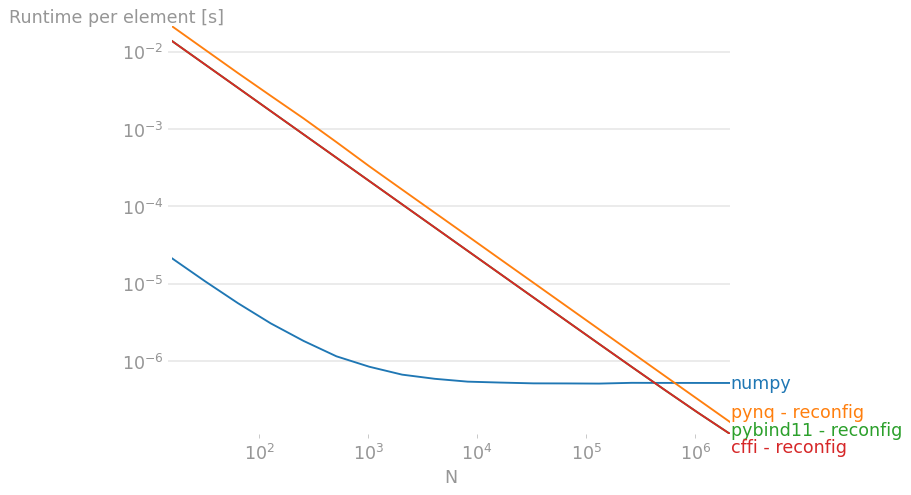

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [17]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [sinh_call_f4_numpy, sinh_call_f4_pynq, sinh_call_f4_pybind11, sinh_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## exp_call_f4


kernel = numpy, n = 16, t = 0.0003452125
kernel = pynq, n = 16, t = 0.1201153367
kernel = pybind11, n = 16, t = 0.0001565612
kernel = cffi, n = 16, t = 0.0002087643
kernel = numpy, n = 32, t = 0.00033563540000000006
kernel = pynq, n = 32, t = 0.1195554515
kernel = pybind11, n = 32, t = 0.0003969511
kernel = cffi, n = 32, t = 0.00031355200000000004
kernel = numpy, n = 64, t = 0.0003559923
kernel = pynq, n = 64, t = 0.11982456650000001
kernel = pybind11, n = 64, t = 0.0001563523
kernel = cffi, n = 64, t = 0.00021902520000000004
kernel = numpy, n = 128, t = 0.00036371820000000003
kernel = pynq, n = 128, t = 0.11961892790000002
kernel = pybind11, n = 128, t = 0.0001788139
kernel = cffi, n = 128, t = 0.00021493170000000001
kernel = numpy, n = 256, t = 0.00041709570000000005
kernel = pynq, n = 256, t = 0.12040823340000001
kernel = pybind11, n = 256, t = 0.0001666274
kernel = cffi, n = 256, t = 0.000214235
kernel = numpy, n = 512, t = 0.0004643108
kernel = pynq, n = 512, t = 0.119734336800000

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.157578125e-05    │ 0.00750720854375  │ 9.785075e-06       │ 1.304776875e-05   │
│ 32      │ 1.048860625000000… │ 0.003736107859375 │ 1.2404721875e-05   │ 9.79850000000000… │
│ 64      │ 5.5623796875e-06   │ 0.00187225885156… │ 2.4430046875e-06   │ 3.42226875000000… │
│ 128     │ 2.841548437500000… │ 0.00093452287421… │ 1.39698359375e-06  │ 1.67915390625000… │
│ 256     │ 1.629280078125000… │ 0.00047034466171… │ 6.5088828125e-07   │ 8.3685546875e-07  │
│ 512     │ 9.0685703125e-07   │ 0.00023385612656… │ 3.598312500000000… │ 4.28019921875000… │
│ 1024    │ 6.0669345703125e-… │ 0.00011689137656… │ 4.136474609375000… │ 1.51855957031250… │
│ 2048    │ 4.340951171875000… │ 5.84942401855468… │ 2.102516601562500… │ 1.17102783203125… │
│ 4096    │ 3.516276367187500… │ 2.91226803222656… │ 1.132602050781250… │ 6.21880371093750… │
│ 8192    │ 3.039103027343750… │ 1.46181993774414… │ 3.018414306640625… │ 4.39229125976562… │
│ 16384   │ 2.879809936523437… │ 7.31211875610351… │ 2.044619140625000… │ 2.68820800781250… │
│ 32768   │ 2.755230926513672… │ 3.66524636230468… │ 1.516847839355469… │ 1.78367095947265… │
│ 65536   │ 2.739077041625977… │ 1.83218182067871… │ 1.555673828125000… │ 1.35213195800781… │
│ 131072  │ 2.722642440795899… │ 9.15493235778808… │ 1.222888717651367… │ 1.13304878234863… │
│ 262144  │ 2.824217453002929… │ 4.58185795211792… │ 1.069003868103027… │ 1.05766803741455… │
│ 524288  │ 2.806326101303101… │ 2.29593915557861… │ 1.031012840270996… │ 1.02971202850341… │
│ 1048576 │ 2.796467870712280… │ 1.15520122623443… │ 1.018720912933349… │ 1.02381218910217… │
│ 2097152 │ 2.790604395389557… │ 5.83029634475708… │ 1.008243651390075… │ 1.00832186222076… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

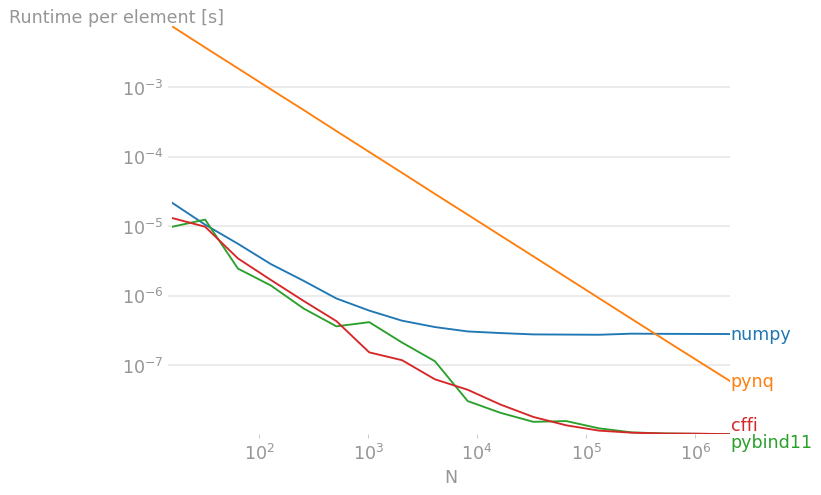

pynq_min = 262144
pybind11_min = 32
cffi_min = 0
Bitstream download time = 0.231380046


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.157578125e-05    │ 0.02196846141875  │ 0.01447103795      │ 0.01447430064375  │
│ 32      │ 1.048860625000000… │ 0.010966734296875 │ 0.007243031159375  │ 0.0072404249375   │
│ 64      │ 5.5623796875e-06   │ 0.00548757207031… │ 0.0036177562234375 │ 0.0036187354875   │
│ 128     │ 2.841548437500000… │ 0.00274217948359… │ 0.001809053592968… │ 0.00180933576328… │
│ 256     │ 1.629280078125000… │ 0.00137417296640… │ 0.000904479192968… │ 0.00090466516015… │
│ 512     │ 9.0685703125e-07   │ 0.00068577027890… │ 0.000452273983593… │ 0.00045234217226… │
│ 1024    │ 6.0669345703125e-… │ 0.00034284845273… │ 0.000226370723632… │ 0.00022610893212… │
│ 2048    │ 4.340951171875000… │ 0.00017147277827… │ 0.000113188789746… │ 0.00011309564086… │
│ 4096    │ 3.516276367187500… │ 8.56119493652343… │ 5.660252924804687… │ 5.65514570800781… │
│ 8192    │ 3.039103027343750… │ 4.28628338989257… │ 2.827481866455078… │ 2.82885574340820… │
│ 16384   │ 2.879809936523437… │ 2.14344360168457… │ 1.414276345214843… │ 1.41491993408203… │
│ 32768   │ 2.755230926513672… │ 1.07264049926757… │ 7.076327108764649… │ 7.07899533996582… │
│ 65536   │ 2.739077041625977… │ 5.36276113586425… │ 3.546136053466797… │ 3.54410063476562… │
│ 131072  │ 2.722642440795899… │ 2.68078289337158… │ 1.777518544769287… │ 1.77662014541625… │
│ 262144  │ 2.824217453002929… │ 1.34083062400817… │ 8.93334867477417e… │ 8.93221509170532… │
│ 524288  │ 2.806326101303101… │ 6.70916329956054… │ 4.516325428009033… │ 4.51619534683227… │
│ 1048576 │ 2.796467870712280… │ 3.36181329822540… │ 2.308484163284301… │ 2.30899329090118… │
│ 2097152 │ 2.790604395389557… │ 1.68633567047119… │ 1.204130401134491… │ 1.20413822221755… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

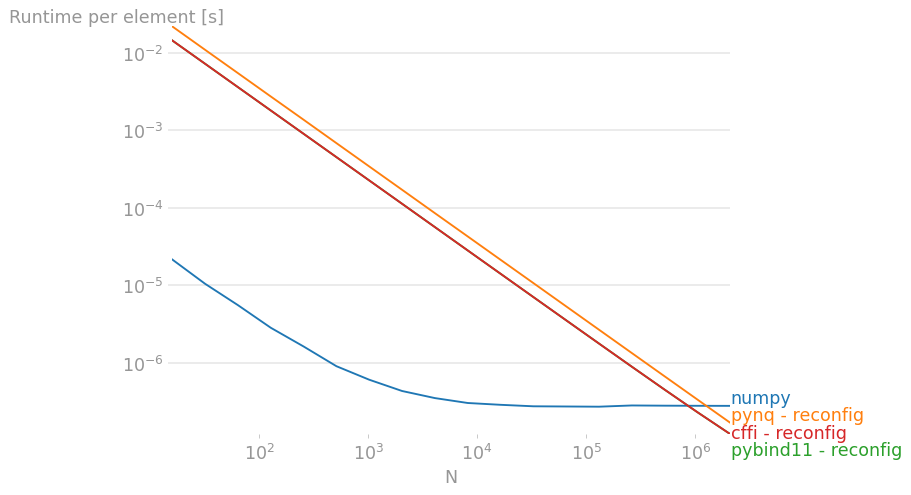

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [18]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [exp_call_f4_numpy, exp_call_f4_pynq, exp_call_f4_pybind11, exp_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")

## log_call_f4


kernel = numpy, n = 16, t = 0.000389829
kernel = pynq, n = 16, t = 0.12128005650000001
kernel = pybind11, n = 16, t = 0.00041760740000000004
kernel = cffi, n = 16, t = 0.00014059940000000001
kernel = numpy, n = 32, t = 0.00033528990000000004
kernel = pynq, n = 32, t = 0.1199431608
kernel = pybind11, n = 32, t = 0.00041984250000000003
kernel = cffi, n = 32, t = 0.0001405234
kernel = numpy, n = 64, t = 0.00035761170000000005
kernel = pynq, n = 64, t = 0.11999113740000002
kernel = pybind11, n = 64, t = 0.0004055988
kernel = cffi, n = 64, t = 0.0001414668
kernel = numpy, n = 128, t = 0.0003711132
kernel = pynq, n = 128, t = 0.1200622791
kernel = pybind11, n = 128, t = 0.0001627037
kernel = cffi, n = 128, t = 0.0002226224
kernel = numpy, n = 256, t = 0.0004052031
kernel = pynq, n = 256, t = 0.1200441777
kernel = pybind11, n = 256, t = 0.00016287379999999999
kernel = cffi, n = 256, t = 0.0002154929
kernel = numpy, n = 512, t = 0.0004681721
kernel = pynq, n = 512, t = 0.1199089426
kernel = py

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.43643125e-05     │ 0.00758000353125… │ 2.610046250000000… │ 8.78746250000000… │
│ 32      │ 1.047780937500000… │ 0.003748223775    │ 1.312007812500000… │ 4.39135625e-06    │
│ 64      │ 5.587682812500001… │ 0.00187486152187… │ 6.33748125e-06     │ 2.21041875e-06    │
│ 128     │ 2.899321875e-06    │ 0.00093798655546… │ 1.27112265625e-06  │ 1.7392375e-06     │
│ 256     │ 1.582824609375e-06 │ 0.00046892256914… │ 6.362257812499999… │ 8.41769140625e-07 │
│ 512     │ 9.143986328125e-07 │ 0.00023419715351… │ 3.277453125000000… │ 4.273142578125e-… │
│ 1024    │ 6.082602539062501… │ 0.00011711995927… │ 1.6956396484375e-… │ 2.1836083984375e… │
│ 2048    │ 4.451310058593750… │ 5.86548208496093… │ 8.971181640625e-08 │ 1.549583984375e-… │
│ 4096    │ 3.65499951171875e… │ 2.93363833984375… │ 5.459587402343751… │ 7.96760253906250… │
│ 8192    │ 3.18945654296875e… │ 1.46566887573242… │ 3.039843750000000… │ 4.50885986328125… │
│ 16384   │ 3.004084228515625… │ 7.32376711425781… │ 3.489028320312500… │ 2.69735595703125… │
│ 32768   │ 2.901645904541016… │ 3.66821806030273… │ 2.224649658203125… │ 1.78039550781250… │
│ 65536   │ 2.873270645141602… │ 1.84026561431884… │ 1.253782348632812… │ 1.35821304321289… │
│ 131072  │ 2.875965576171875… │ 9.18266833496093… │ 1.226154327392578… │ 1.12360260009765… │
│ 262144  │ 2.979504295349121… │ 4.61781005096435… │ 1.070213661193847… │ 1.05852462768554… │
│ 524288  │ 2.957716753005981… │ 2.29697829818725… │ 1.033744335174560… │ 1.03454666137695… │
│ 1048576 │ 2.950935587882996… │ 1.15823907566070… │ 1.018911924362182… │ 1.02408245086669… │
│ 2097152 │ 2.942448398590087… │ 5.84471412658691… │ 1.008251552581787… │ 1.00802692413330… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

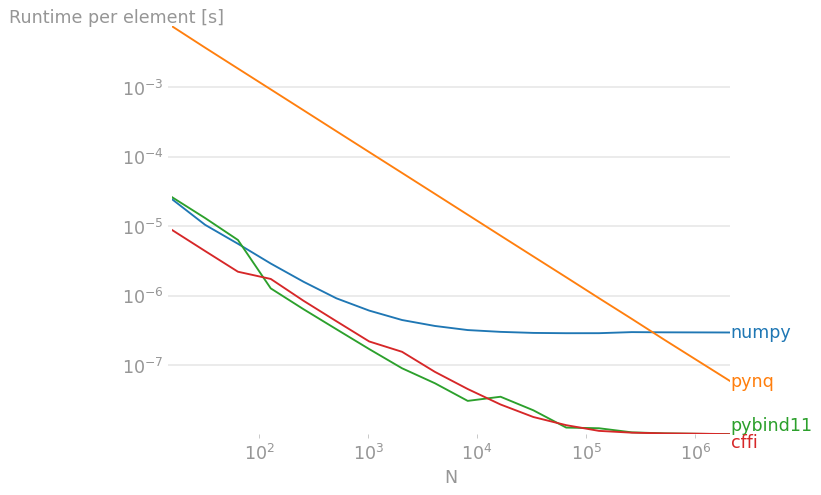

pynq_min = 262144
pybind11_min = 64
cffi_min = 0
Bitstream download time = 0.21908827700000003


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 2.43643125e-05     │ 0.02127302084375… │ 0.013719117775000… │ 0.01370180477500… │
│ 32      │ 1.047780937500000… │ 0.01059473243125  │ 0.006859628734375… │ 0.00685090001250… │
│ 64      │ 5.587682812500001… │ 0.00529811585000… │ 0.003429591809375… │ 0.00342546474687… │
│ 128     │ 2.899321875e-06    │ 0.00264961371953… │ 0.001712898286718… │ 0.00171336640156… │
│ 256     │ 1.582824609375e-06 │ 0.00132473615117… │ 0.000856449807812… │ 0.00085665535117… │
│ 512     │ 9.143986328125e-07 │ 0.00066210394453… │ 0.000428234536328… │ 0.00042833410527… │
│ 1024    │ 6.082602539062501… │ 0.00033107335478… │ 0.000214122959472… │ 0.00021417175634… │
│ 2048    │ 4.451310058593750… │ 0.00016563151860… │ 0.000107066409570… │ 0.00010713165615… │
│ 4096    │ 3.65499951171875e… │ 8.28247322753906… │ 5.354294475097657… │ 5.35680249023437… │
│ 8192    │ 3.18945654296875e… │ 4.14008631958007… │ 2.677457287597656… │ 2.67892630371093… │
│ 16384   │ 3.004084228515625… │ 2.06958543334960… │ 1.340697750244140… │ 1.33990607788085… │
│ 32768   │ 2.901645904541016… │ 1.03542616699218… │ 6.708290106201173… │ 6.70384756469726… │
│ 65536   │ 2.873270645141602… │ 5.18328741912841… │ 3.355559628295899… │ 3.35660393524169… │
│ 131072  │ 2.875965576171875… │ 2.58977773590087… │ 1.683772445678711… │ 1.68274692840576… │
│ 262144  │ 2.979504295349121… │ 1.29753645629882… │ 8.464575878143312… │ 8.46340697479248… │
│ 524288  │ 2.957716753005981… │ 6.47575555419922… │ 4.282151689529419… │ 4.28223192214965… │
│ 1048576 │ 2.950935587882996… │ 3.24762770366668… │ 2.1912798204422e-… │ 2.19179687309265… │
│ 2097152 │ 2.942448398590087… │ 1.62916572666168… │ 1.145519469261169… │ 1.14549700641632… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

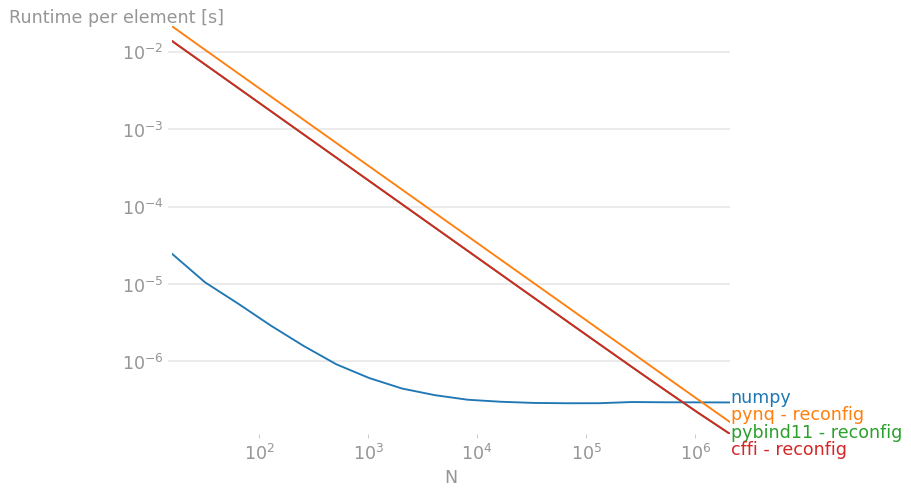

pynq_min_reconf = 1048576
pybind11_min_reconf = 524288
cffi_min_reconf = 524288


In [19]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [log_call_f4_numpy, log_call_f4_pynq, log_call_f4_pybind11, log_call_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/ufunc_call_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")